In [2]:
import tracemalloc
import pickle
from skylens import *
from survey_utils import *
from scipy.stats import norm,mode,skew,kurtosis,percentileofscore
import seaborn as sns
colors=sns.color_palette()
markers=['o','s','^','>','v']

In [5]:
import survey_utils
import skylens
import tracer_utils
import window_utils
import cov_utils
import importlib
reload=importlib.reload
reload(survey_utils)
reload(window_utils)
reload(cov_utils)
reload(tracer_utils)
reload(skylens)
from survey_utils import *
from cov_utils import *
from skylens import *

In [6]:
import jk_utils
reload(jk_utils)
from jk_utils import *



In [7]:
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [8]:
fig_home='./figures/'

In [9]:
from distributed import LocalCluster
from dask.distributed import Client  # we already had this above
#http://distributed.readthedocs.io/en/latest/_modules/distributed/worker.html
worker_kwargs={'memory_spill_fraction':.75,'memory_target_fraction':.99,'memory_pause_fraction':1}
LC=LocalCluster(n_workers=1,processes=False,memory_limit='60gb',threads_per_worker=10,
                local_dir='/home/deep/repos/cosmic_shear/temp/NGL-worker/',
               **worker_kwargs,
                #scheduler_port=12234,
#                 dashboard_address=8801
                diagnostics_port=8801,
#                memory_monitor_interval='2000ms')
               )
client=Client(LC,diagnostics_port=8801,)

#LC.close()
#client.close()

/usr/local/lib/python3.8/dist-packages/distributed/deploy/local.py:137: UserWarning: diagnostics_port has been deprecated. Please use `dashboard_address=` instead
  warnings.warn(


In [10]:
client

Client Scheduler: inproc://192.168.86.87/4003/1,Cluster Workers: 1 Cores: 10 Memory: 60.00 GB


In [11]:
nside=1024
l0w=np.arange(3*nside-1)

In [12]:
#setup parameters
# lmax_cl=int(nside*2.9)
lmax_cl=1920
lmin_cl=0
l0=np.arange(lmin_cl,lmax_cl)

lmin_cl_Bins=lmin_cl+10
lmax_cl_Bins=lmax_cl-10
Nl_bins=37 #40
l_bins=np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins))
# l_bins=np.int64(np.linspace(lmin_cl_Bins,lmax_cl_Bins,Nl_bins))
lb=(l_bins[1:]+l_bins[:-1])*.5

l=l0 #np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20))) #if we want to use fewer ell

do_cov=True
bin_cl=True

SSV_cov=False
tidal_SSV_cov=False

do_xi=False

In [13]:
use_shot_noise=False

In [14]:
use_window=True
f_sky=0.3
n_source_bins=1
sigma_gamma=0.3944/sqrt(2.)  #*2**0.25

In [15]:
store_win=True
unit_window=True
smooth_window=False

In [16]:
w_smooth_lmax=1.e7 #some large number
if smooth_window:
    w_smooth_lmax=1000
window_cl_fact=np.cos(np.pi/2*(l0w/w_smooth_lmax)**10)
x=window_cl_fact<0
x+=l0w>w_smooth_lmax
window_cl_fact[x]=0
if unit_window:
    window_cl_fact=0

In [17]:
corr_ggl=('galaxy','shear')
corr_gg=('galaxy','galaxy')
corr_ll=('shear','shear')

In [18]:
labels={}
labels[corr_gg]=r'$gg$'
labels[corr_ll]=r'$\gamma\gamma$'
labels[corr_ggl]=r'$g \gamma$'

corr_labels={}
corr_labels[corr_ll]=r'$\gamma\gamma^{EE}$'
corr_labels[corr_gg]=r'$gg$'
corr_labels[corr_ggl]=r'$g\gamma$'

corr_fnames={}
corr_fnames[corr_ll]='ll'
corr_fnames[corr_gg]='gg'
corr_fnames[corr_ggl]='ggl'




In [19]:
do_cov=True
store_win=True

In [20]:
wigner_files={}
wigner_files[0]= 'temp/dask_wig3j_l6500_w2100_0_reorder.zarr'
wigner_files[2]= 'temp/dask_wig3j_l3500_w2100_2_reorder.zarr'



In [21]:
corrs=[corr_ll,corr_ggl,corr_gg]
# window_lmax=300
window_lmax=2000

In [22]:
th_min=1./60
th_max=600./60
n_th_bins=20
th_bins=np.logspace(np.log10(th_min),np.log10(th_max),n_th_bins+1)
th=np.logspace(np.log10(th_min*0.98),np.log10(1),n_th_bins*30)
th2=np.linspace(1,th_max*1.02,n_th_bins*30)
# th2=np.logspace(np.log10(1),np.log10(th_max),60*6)
th=np.unique(np.sort(np.append(th,th2)))
thb=np.sqrt(th_bins[1:]*th_bins[:-1])

bin_xi=True

# HT_kwargs={'l_min':l_min,  'l_max':l_max,
#                         'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
#                         'n_zeros':40000, 'prune_theta':prune_theta, 'm1_m2':[(2,2),(2,-2),(0,2),(0,0)]}
l0_win=np.arange(lmax_cl)
WT_L_kwargs={'l': l0_win,'theta': th*d2r,'m1_m2':[(2,2),(2,-2),(0,2),(2,0),(0,0)]}
WT_L=None
if do_xi:
    %time WT_L=wigner_transform(**WT_L_kwargs)

(0.001, 1000.0)

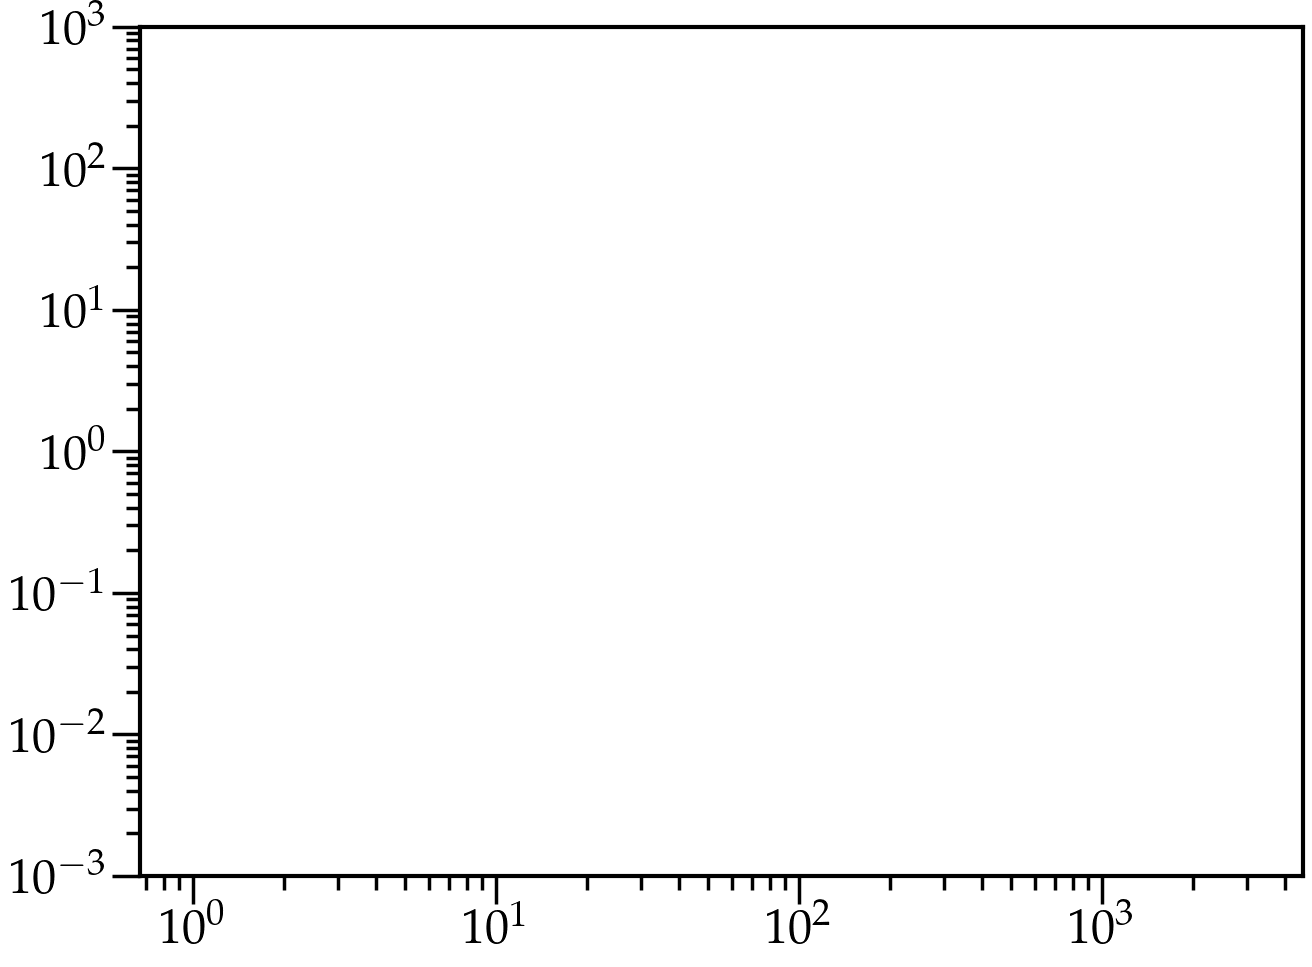

In [23]:
# l0w=np.arange(512)+1
mean=150
sigma=50
ww=1000*np.exp(-(l0w-mean)**2/sigma**2)
x=ww<1
ww[x]=1
# x=l0w>mean+3*sigma
# ww[x]=ww[l0w==mean+3*sigma]
loglog(l0w,ww*window_cl_fact)
ylim(1.e-3,1e3)

In [24]:
z0=0.5
zl_bin1=lsst_source_tomo_bins(zp=np.array([z0]),ns0=10,use_window=use_window,nbins=1,window_cl_fact=window_cl_fact,
                         f_sky=f_sky,nside=nside,unit_win=False,use_shot_noise=True)#p_zp=np.array([1]),
zl_bin1w=lsst_source_tomo_bins(zp=np.array([z0]),ns0=30,use_window=use_window,window_cl_fact=window_cl_fact*(1+ww),
                              f_sky=f_sky,nbins=n_source_bins,nside=nside,use_shot_noise=True)#p_zp=np.array([1]),

ns0:  10.0
indxs:  None None
Win gen: step size 1368
Window done


./cov_utils.py:58: RuntimeWarning: invalid value encountered in true_divide
  Win0=2*jn(1,l_th)/l_th
./angular_power_spectra.py:26: RuntimeWarning: divide by zero encountered in true_divide
  self.cl_f=(l+0.5)**2/(l*(l+1.)) # cl correction from Kilbinger+ 2017
/usr/local/lib/python3.8/dist-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/local/lib/python3.8/dist-packages/healpy/sphtfunc.py:396: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  warnings.warn(


In [25]:
z0=1 #1087
zs_bin1=lsst_source_tomo_bins(zp=np.array([z0]),ns0=30,use_window=use_window,window_cl_fact=window_cl_fact,
                              f_sky=f_sky,nbins=n_source_bins,nside=nside,unit_win=False,use_shot_noise=True) #p_zp=np.array([1])

zs_bin1w=lsst_source_tomo_bins(zp=np.array([z0]),ns0=30,use_window=use_window,window_cl_fact=(1+ww)*window_cl_fact,
                              f_sky=f_sky,nbins=n_source_bins,nside=nside,use_shot_noise=True)#p_zp=np.array([1])

In [26]:
subsample=False
do_cov_jk=False #compute covariance coupling matrices

In [27]:
njk1=10
njk2=njk1
njk=njk1*njk2

mask=zs_bin1[0]['window']>-1000
mask=mask.astype('bool')
jkmap=jk_map(mask=mask,nside=nside,njk1=njk1,njk2=njk2)

In [28]:
f_sky_jk=f_sky*(njk-1.)/njk
if subsample:
    f_sky_jk=f_sky/njk

In [29]:
import window_utils
reload(window_utils)
from window_utils import *

import tracer_utils
reload(tracer_utils)
from tracer_utils import *


import skylens
reload(skylens)
from skylens import *

In [30]:
client

Client Scheduler: inproc://192.168.86.87/4003/1,Cluster Workers: 1 Cores: 10 Memory: 60.00 GB


In [31]:
zs_bin1['SN']['galaxy']

array([[[2.50350109e-07]]])

In [32]:
if not use_shot_noise:
    for t in zs_bin1['SN'].keys():
        zs_bin1['SN'][t]*=0
        zs_bin1w['SN'][t]*=0
        zl_bin1w['SN'][t]*=0
        zl_bin1['SN'][t]*=0

In [34]:
tracemalloc.clear_traces()
tracemalloc.start()


t1=time.time()
kappa_win=Skylens(zs_bins=zs_bin1,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, zg_bins=zl_bin1,
            use_window=use_window,store_win=store_win,window_lmax=window_lmax,corrs=corrs,
            SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=f_sky,
            WT=WT_L,bin_xi=bin_xi,theta_bins=th_bins,do_xi=do_xi,
                  wigner_files=wigner_files,
#                  Win=kappa_win.Win.Win
                 )

t2=time.time()
print('W done',t2-t1)
%time clG_win=kappa_win.cl_tomo(corrs=corrs) 
%time cl0_win=clG_win['stack'].compute()

if do_xi:
    %time xiWG_L=kappa_win.xi_tomo()
    %time xiW_L=xiWG_L['stack'].compute()

In [ ]:
zs_bin1.keys()

In [ ]:
snapshot1 = tracemalloc.take_snapshot()

In [ ]:
top_stats = snapshot1.statistics('lineno')
# top_stats

In [ ]:
stat = top_stats[3]
print("%s memory blocks: %.1f MiB" % (stat.count, stat.size / 1024**2))
for line in stat.traceback.format():
    print(line)

In [ ]:
l=kappa_win.window_l
Om_W=np.pi*4*f_sky
theta_win=np.sqrt(Om_W/np.pi)
l_th=l*theta_win
Win0=2*jn(1,l_th)/l_th
Win0=np.nan_to_num(Win0)

In [ ]:
kappa_win.z_bins.keys()

In [ ]:
bi=(0,0)

In [ ]:
R=kappa_win.Win.Win['cl'][corr_gg][bi]['M']/kappa_win.Win.Win['cl'][corr_ll][bi]['M']
R=np.nan_to_num(R)
x=R>0
R[x].max()

In [ ]:
kappa0=Skylens(zs_bins=zs_bin1,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, zg_bins=zl_bin1,
            use_window=False,store_win=store_win,corrs=corrs,
            SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=f_sky,
            HT=WT_L,bin_xi=bin_xi,theta_bins=th_bins,do_xi=do_xi)

%time clG0=kappa0.cl_tomo(corrs=corrs) 
%time cl0=clG0['stack'].compute()

if do_xi:
    %time xiG_L0=kappa0.xi_tomo()
    %time xi_L0=xiG_L0['stack'].compute()

In [ ]:
zl_bin1[0]['lm']

In [ ]:
bi=(0,0)
cl0={'cl_b':{},'cov':{},'cl':{}}
cl0_win_w={'cl_b':{},'cov':{}}
cl0_win={'cl_b':{},'cov':{}}
for corr in corrs:
    cl0['cl_b'][corr]=clG0['cl_b'][corr][bi].compute()
    cl0['cl'][corr]=clG0['cl'][corr][bi].compute()
    cl0['cov'][corr]=clG0['cov'][corr+corr][bi+bi].compute()
    
    cl0_win['cl_b'][corr]=clG_win['cl_b'][corr][bi].compute()
    cl0_win['cov'][corr]=clG_win['cov'][corr+corr][bi+bi].compute()['final_b']
    
#     cl0_win_w['cl_b'][corr]=clG_win_w['cl_b'][corr][bi].compute()
#     cl0_win_w['cov'][corr]=clG_win_w['cov'][corr+corr][bi+bi].compute()['final_b']

In [ ]:
import binning
reload(binning)
from binning import *
M_binnings={}
M_binning_utils={}
Mp_binning_utils={}
Mwp_binning_utils={}
Mw_binning_utils={}
for corr in corrs:
    M_binnings[corr]=binning()
    wt_b=1./cl0['cl_b'][corr]
    wt0=cl0['cl'][corr]
    M_binning_utils[corr]=M_binnings[corr].bin_utils(r=kappa0.l,r_bins=kappa0.l_bins,
                                                r_dim=2,mat_dims=[1,2],wt_b=wt_b,wt0=wt0)
    Mw_binning_utils[corr]=M_binnings[corr].bin_utils(r=kappa0.l,r_bins=kappa0.l_bins,
                                                r_dim=2,mat_dims=[1,2],wt_b=wt_b,wt0=wt0)
    wt_b=1./clG_win['cl_b'][corr].compute()[bi]
    wt0=clG_win['pseudo_cl'][corr][bi].compute()
    Mp_binning_utils[corr]=M_binnings[corr].bin_utils(r=kappa0.l,r_bins=kappa0.l_bins,
                                                r_dim=2,mat_dims=[1,2],wt_b=wt_b,wt0=wt0)
    
#     wt_b=1./clG_win_w['cl_b'][corr].compute()[bi]
#     wt0=clG_win_w['pseudo_cl'][corr][bi].compute()
#     Mwp_binning_utils[corr]=M_binnings[corr].bin_utils(r=kappa0.l,r_bins=kappa0.l_bins,
#                                                 r_dim=2,mat_dims=[1,2],wt_b=wt_b,wt0=wt0)

In [ ]:
plot(lb,cl0['cl_b'][corr_ll])
plot(l0,cl0['cl'][corr_ll])
loglog()

In [ ]:
plot(lb,cl0['cl_b'][corr_gg])
plot(l0,cl0['cl'][corr_gg])
loglog()

In [ ]:
mask=zs_bin1[0]['window']>-1.e-20

In [ ]:
win2=zs_bin1[0]['window']/zs_bin1[0]['window']
win2[~mask]=hp.UNSEEN
win2[mask]=1.
cl_t2=hp.anafast(win2)

In [ ]:
def get_coupling_matrices_jk(kappa_class=None): 
    coupling_M={}
    coupling_M['full']=get_coupling_matrices(kappa_class=kappa_win)
    for ijk in np.arange(njk):
        zs_binjk=copy.deepcopy(kappa_class.z_bins['shear'])
        zl_binjk=copy.deepcopy(kappa_class.z_bins['galaxy'])

        x=jkmap==ijk
        for i in np.arange(zs_binjk['n_bins']):
            if subsample:
                zs_binjk[i]['window'][~x]=hp.UNSEEN
            else:
                zs_binjk[i]['window'][x]=hp.UNSEEN
            zs_binjk[i]['window_alm']=hp.map2alm(zs_binjk[i]['window'])
            zs_binjk[i]['window_cl']=None
        for i in np.arange(zl_binjk['n_bins']):
            if subsample:
                zl_binjk[i]['window'][~x]=hp.UNSEEN
            else:
                zl_binjk[i]['window'][x]=hp.UNSEEN
            zl_binjk[i]['window_alm']=hp.map2alm(zl_binjk[i]['window'])
            zl_binjk[i]['window_cl']=None

        kappa_win_JK=Skylens(zs_bins=zs_binjk,do_cov=do_cov_jk,bin_cl=bin_cl,l_bins=l_bins,l=l0, zg_bins=zl_binjk,
                use_window=use_window,store_win=store_win,window_lmax=window_lmax,corrs=corrs,
                SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=f_sky_jk,
                HT=WT_L,bin_xi=bin_xi,theta_bins=th_bins,do_xi=do_xi,
                      wigner_files=wigner_files,
    #                  Win=kappa_win.Win.Win
                     )
        coupling_M[ijk]=get_coupling_matrices(kappa_class=kappa_win_JK)
        del kappa_win_JK
        del zs_binjk
        del zl_binjk
    return coupling_M

In [ ]:
def get_coupling_matrices(kappa_class=None): 
    coupling_M={}
    coupling_M_N={}
    coupling_M_binned={'Master':{},'nMaster':{},'iMaster':{}}    
    coupling_M_inv={}
    coupling_M_binned_inv={'Master':{},'nMaster':{},'iMaster':{}}
    
    coupling_M4={}
    coupling_M4_binned={}
    coupling_M4_binned2={}

    corrs=kappa_class.corrs
    l_bins=kappa_class.l_bins
    fsky=kappa_class.f_sky[corr_gg][(0,0)]
    dl=l_bins[1:]-l_bins[:-1]
    l=kappa_class.l
    shear_lcut=l>=2
    nu=(2.*l+1.)*fsky
    for corr in corrs:
        coupling_M[corr]=kappa_class.Win.Win['cl'][corr][(0,0)]['M']
        coupling_M_N[corr]=kappa_class.Win.Win['cl'][corr][(0,0)]['M_noise']
        if corr==corr_ll:
            coupling_M['shear_B']=kappa_class.Win.Win['cl'][corr][(0,0)]['M_B']
            coupling_M_N['shear_B']=kappa_class.Win.Win['cl'][corr][(0,0)]['M_B_noise']
        coupling_M_binned['Master'][corr]=bin_coupling_M(kappa_class,coupling_M[corr])
        coupling_M_binned['nMaster'][corr]=kappa_class.binning.bin_2d(cov=coupling_M[corr],bin_utils=kappa_class.cl_bin_utils) 
        coupling_M_binned['nMaster'][corr]*=dl

        coupling_M_binned['iMaster'][corr]=M_binnings[corr].bin_2d_coupling(cov=coupling_M[corr].T,bin_utils=M_binning_utils[corr])
        coupling_M_binned['iMaster'][corr]=coupling_M_binned['iMaster'][corr].T  #to keep the same order in dot product later. Remeber that the coupling matrix is not symmetric.

        if corr==corr_ll:
            coupling_M_binned['iMaster']['shear_B']=M_binnings[corr].bin_2d_coupling(cov=coupling_M['shear_B'].T,bin_utils=M_binning_utils[corr])
            coupling_M_binned['iMaster']['shear_B']=coupling_M_binned['iMaster']['shear_B'].T  #to keep the same order in dot product later. Remeber that the coupling matrix is not symmetric.


#             coupling_M4=kappa_win.Win.Win['cov'][corr+corr][(0,0,0,0)]['M1324'][s] #*2
#             coupling_M4_binned[corr]=bin_coupling_M(kappa_class,coupling_M4[corr])
#             coupling_M4_binned2[corr]=kappa_class.binning.bin_2d(cov=coupling_M4[corr],bin_utils=kappa_class.cl_bin_utils) 
#             coupling_M4_binned2[corr]*=dl
#         kappa_class.binning.bin_2d(cov=coupling_M,bin_utils=kappa_win.cl_bin_utils)
#             print(corr,coupling_M[corr])

        cut=l>=0
        if 'shear' in corr:
            cut=shear_lcut 
        coupling_M_inv[corr]=np.zeros_like(coupling_M[corr])
#             coupling_M_inv[corr][:,cut][cut,:]+=np.linalg.inv(coupling_M[corr][cut,:][:,cut]) #otherwise we get singular matrix since for shear l<2 is not defined.
        MT=np.linalg.inv(coupling_M[corr][cut,:][:,cut]) #otherwise we get singular matrix since for shear l<2 is not defined.
        coupling_M_inv[corr]=np.pad(MT,((~cut).sum(),0),mode='constant',constant_values=0)

        for k in coupling_M_binned.keys():
            coupling_M_binned_inv[k][corr]=np.linalg.inv(coupling_M_binned[k][corr])
        if corr==corr_ll:
            coupling_M_inv['shear_B']=np.zeros_like(coupling_M['shear_B'])
            coupling_M_inv['shear_B'][:,cut][cut,:]=np.linalg.inv(coupling_M['shear_B'][cut,:][:,cut]) #otherwise we get singular matrix since for shear l<2 is not defined.
            coupling_M_binned_inv['iMaster']['shear_B']=np.linalg.inv(coupling_M_binned['iMaster']['shear_B'])

    outp={}
    outp['coupling_M']=coupling_M
    outp['coupling_M_N']=coupling_M_N
    outp['coupling_M_binned']=coupling_M_binned
    outp['coupling_M_inv']=coupling_M_inv
    outp['coupling_M_binned_inv']=coupling_M_binned_inv
    
    outp['coupling_M4']=coupling_M4
    outp['coupling_M4_binned']=coupling_M4_binned
    outp['coupling_M4_binned2']=coupling_M4_binned2

    return outp


In [ ]:
def get_cljk(cl_map,lmax=np.int(l0.max()),pol=True,coupling_M={}):
    clp_jk={}
    for ijk in np.arange(njk):
        x=jkmap==ijk
        cl_map_i=copy.deepcopy(cl_map)
        if subsample:
            cl_map_i[:,~x]=hp.UNSEEN
        else:
            cl_map_i[:,x]=hp.UNSEEN

        clp_jk[ijk]=hp.anafast(cl_map_i,lmax=lmax,pol=pol)
    return clp_jk

def jk_mean(p={},njk=njk):
#     if check_empty(p):
#         print ('jk-mean: got empty dict')
#         return p
    p2={}
    nn=np.arange(njk)
    for i in nn: #p.keys():
        #if i in nn:
        p2[i]=p[i]
    jk_vals=np.array(list(p2.values()))
    mean=np.mean(jk_vals,axis=0)
    var=np.var(jk_vals,axis=0,ddof=0)
    try:
        cov=np.cov(jk_vals,rowvar=0)
    except Exception as err:
#         print(jk_vals.shape, err)
        cov=np.cov(jk_vals.reshape(njk, jk_vals.shape[2]*jk_vals.shape[1]),rowvar=0)
    if subsample:
        var/=njk
        cov/=njk
    else:
        cov*=(njk-1)
    p['jk_mean']=mean
    p['jk_err']=np.sqrt(var) 
    p['jk_cov']=cov
    p['jk_corr']=corr_matrix(cov_mat=cov)
    return p

def sample_mean(p={},nsamp=100):
#     if check_empty(p):
#         print ('sample-mean: got empty dict')
#         return p
    p2={}
    nn=np.arange(nsamp)
    for i in nn: #p.keys():
        #if i in nn:
        p2[i]=p[i]
    jk_vals=np.array(list(p2.values()))
    mean=np.mean(jk_vals,axis=0)
    #print mean
    var=np.var(jk_vals,axis=0,ddof=0)
    p['mean']=mean
    p['err']=np.sqrt(var)
    try:
        cov=np.cov(jk_vals,rowvar=0)
        p['cov']=cov
        p['corr']=corr_matrix(cov_mat=cov)
    except Exception as err:
        p['cov']=err
        p['corr']=err
    return p

In [ ]:
def corr_matrix(cov_mat=[]): #correlation matrix
    diag=np.diag(cov_mat)
    return cov_mat/np.sqrt(np.outer(diag,diag))

In [ ]:
def bin_coupling_M(kappa_class,coupling_M): #following https://arxiv.org/pdf/astro-ph/0105302.pdf 
#construct coupling matrix for the binned c_ell. This assumes that the C_ell within a bin follows powerlaw. 
#Without this assumption we cannot undo the effects of binning
    l=kappa_class.l
    bin_M=kappa_win.cl_bin_utils['binning_mat']
    l2=l*(l+1)
    x=l==0
    l2[x]=1
    Q=bin_M.T*np.pi*2/(l2)
    P=bin_M.T*(l2)/(np.pi*2)
    P=P.T/(kappa_class.l_bins[1:]-kappa_class.l_bins[:-1])
    return P.T@coupling_M@Q.T

In [ ]:
def bin_coupling_M2(kappa_class,coupling_M): #following https://arxiv.org/pdf/astro-ph/0105302.pdf 
#construct coupling matrix for the binned c_ell. This assumes that the C_ell within a bin follows powerlaw. 
#Without this assumption we cannot undo the effects of binning
    l=kappa_class.l
    bin_M=kappa_win.cl_bin_utils['binning_mat']
    
    l2=l*(l+1)
    x=l==0
    l2[x]=1
    
    Q=bin_M.T*np.pi*2/(l2)**2
    P=bin_M.T*(l2)**2/(np.pi*2)
    P=P.T/(kappa_class.l_bins[1:]-kappa_class.l_bins[:-1])
    return P.T@coupling_M@Q.T

In [ ]:
seed=12334
def get_clsim2(clg0,window,mask,kappa_class,coupling_M,ndim,i):
    print(i)
    local_state = np.random.RandomState(seed+i)
    cl_map=hp.synfast(clg0,nside=nside,RNG=local_state,new=True,pol=True)

    if ndim>1:
        cl_map[0]*=window['galaxy']
        cl_map[0][mask['galaxy']]=hp.UNSEEN
        cl_map[1]*=window['shear'] #shear_1
        cl_map[2]*=window['shear']#shear_2
        cl_map[1][mask['shear']]=hp.UNSEEN
        cl_map[2][mask['shear']]=hp.UNSEEN
        clpi=hp.anafast(cl_map, lmax=max(l),pol=True) #TT, EE, BB, TE, EB, TB for polarized input map
        clpi=clpi[:,l]
        clpi=clpi[[0,1,3],:]
#             for i in np.arange(6):

    else:
        cl_map*=window
        cl_map[mask]=hp.UNSEEN
        clpi=hp.anafast(cl_map, lmax=max(l),pol=True)[l]
        
    del cl_map

    if ndim>1:
        clpi[0]-=(np.ones_like(clpi[0])*kappa_class.SN[corr_gg][:,0,0])@coupling_M['coupling_M'][corr_gg]*use_shot_noise
        clpi[1]-=(np.ones_like(clpi[1])*kappa_class.SN[corr_ll][:,0,0])@coupling_M['coupling_M'][corr_ll]*use_shot_noise
        clpi[1]-=(np.ones_like(clpi[1])*kappa_class.SN[corr_ll][:,0,0])@coupling_M['coupling_M']['shear_B']*use_shot_noise #remove B-mode leakage

        clgi=[clpi[0]@coupling_M['coupling_M_inv'][corr_gg],
              clpi[1]@coupling_M['coupling_M_inv'][corr_ll],
              clpi[2]@coupling_M['coupling_M_inv'][corr_ggl]]
    else:
        clpi-=(np.ones_like(clpi)*shot_noise)@coupling_M['coupling_M']
        clgi=clpi@coupling_M['coupling_M_inv']
    clgi=np.array(clgi)
    return [clpi.T,clgi.T]

In [ ]:
def calc_sim_stats(sim=[],sim_truth=[],PC=False):
    sim_stats={}
    sim_stats['std']=np.std(sim,axis=0)    
    sim_stats['mean']=np.mean(sim,axis=0)
    sim_stats['median']=np.median(sim,axis=0)
    sim_stats['percentile']=np.percentile(sim,[16,84],axis=0)
#     sim_stats['skew']=skew(sim,axis=0)
#     sim_stats['kurt']=kurtosis(sim,axis=0)
    sim_stats['cov']=np.cov(sim,rowvar=0)
    
#     if not PC:
#         try:
#             sim_stats['cov_ev'],sim_stats['cov_evec']=np.linalg.eig(sim_stats['cov'])
#             sim_stats['PC']={}
#             sim_stats['PC']['data']=(sim_stats['cov_evec'].T@sim.T).T
#             sim_stats['PC']['stats']=calc_sim_stats(sim=sim_stats['PC']['data'],PC=True)
#         except Exception as err:
#             print(err)
#             sim_stats['PC']=err
#     else:
#         sim_truth=sim_stats['mean']
    
    sim_stats['percetile_score']=np.zeros_like(sim_stats['std'])
    if len(sim_stats['std'].shape)==1:
        for i in np.arange(len(sim_stats['std'])):
            sim_stats['percetile_score'][i]=percentileofscore(sim[:,i],sim_truth[i])
    elif len(sim_stats['std'].shape)==2:
        for i in np.arange(len(sim_stats['std'])):
            for i_dim in np.arange(2):
                for j_dim in np.arange(2):
                    sim_stats['percetile_score'][i][i_dim,j_dim]=percentileofscore(sim[:,i,i_dim,j_dim],
                                                                                   sim_truth[i,i_dim,j_dim])
    else:
        sim_stats['percetile_score']='not implemented for ndim>2'
    return sim_stats
    
def sim_cl_xi(Rsize=150,do_norm=False,cl0=None,kappa_class=None,fsky=f_sky,zbins=None,use_shot_noise=True,
             convolve_win=False,nside=nside,use_cosmo_power=True,lognormal=False,lognormal_scale=1,
             coupling_M=None):
    l=kappa_class.l
    shear_lcut=l>=2
    
    l_bins=kappa_class.l_bins
    dl=l_bins[1:]-l_bins[:-1]
    nu=(2.*l+1.)*fsky
    
    mask={}
    window={}
    if convolve_win:
        nu=2.*l+1.
        for tracer in kappa_class.z_bins.keys():
            window[tracer]=kappa_class.z_bins[tracer][0]['window']
            mask[tracer]=window[tracer]==hp.UNSEEN
#             print(coupling_M_inv.keys())
    outp={}
    win=0
    clp_shear_B=None
    if cl0 is None:
        cl0={}
        clp0={}
        clG0=kappa_class.cl_tomo() 
        for corr in kappa_class.corrs:
            cl0[corr]=clG0['cl'][corr][(0,0)].compute()
            clp0[corr]=clG0['cl_b'][corr][(0,0)].compute()
    clg0={}
    clN0={}
    for corr in kappa_class.corrs: #ordering: TT, EE, BB, TE if 4 cl as input.. use newbool=True
        shot_noise=kappa_class.SN[corr_gg][:,0,0]*0
        if corr[0]==corr[1]:
            shot_noise=kappa_class.SN[corr][:,0,0]
        shot_noise=shot_noise*use_shot_noise
        clN0[corr]=shot_noise
        clg0[corr]=cl0[corr]*use_cosmo_power#+shot_noise
        if corr==corr_ll:
            clg0['shear_B']=cl0[corr]*0
            clN0['shear_B']=shot_noise
            #clp_shear_B=shot_noise@coupling_M[corr_ll]+(cl0[corr_ll]+shot_noise)@coupling_M['shear_B']
            clp_shear_B=cl0[corr_ll]@coupling_M['full']['coupling_M']['shear_B']
    ndim=len(kappa_class.corrs)
    print('ndim:',ndim)
    outp['clg0_0']=clg0.copy()
    outp['clN0_0']=clN0.copy()
    outp['ndim']=ndim
    if ndim>1:
        clg0=(clg0[corr_gg],clg0[corr_ll],clg0['shear_B'],clg0[corr_ggl])#ordering: TT, EE, BB, TE if 4 cl as input.. use newbool=True
        clN0=(clN0[corr_gg],clN0[corr_ll],clN0['shear_B'],clN0[corr_ggl])#ordering: TT, EE, BB, TE if 4 cl as input.. use newbool=True
    else:
        clg0=clg0[corr_gg]
        clN0=clN0[corr_gg]
    
    SN=kappa_class.SN
    sim_cl_shape=(Rsize,len(kappa_class.l),ndim)
    
    jk_stat_keys=['jk_mean','jk_err','jk_cov']
    clp={'full':np.zeros(sim_cl_shape,dtype='float32')}
    clp.update({jks:{} for jks in jk_stat_keys})
    clg={'full':np.zeros(sim_cl_shape,dtype='float32')}
    clg.update({jks:{} for jks in jk_stat_keys})
    clpB={'full':np.zeros(sim_cl_shape,dtype='float32')}
    clpB.update({jks:{} for jks in jk_stat_keys})
    clgB={'full':np.zeros(sim_cl_shape,dtype='float32')}
    clgB.update({jks:{} for jks in jk_stat_keys})
    cl_maps={}
    lmax=max(l)
    lmin=min(l)
    
    
    clg_b=None
    clp_b=None
    clpB_b=None
    nu_b=None
    if l_bins is not None:
        clg0_b={corr: kappa_class.binning.bin_1d(xi=cl0[corr],bin_utils=kappa_class.cl_bin_utils) for corr in kappa_class.corrs} 
        ll=kappa_class.cl_bin_utils['bin_center']
        sim_clb_shape=(Rsize,len(ll),ndim)
        nu_b=(2.*ll+1.)*fsky*(l_bins[1:]-l_bins[:-1])
        Master_algs=['unbinned','Master','nMaster','iMaster']
        clg_b={'full':{im:np.zeros(sim_clb_shape,dtype='float32') for im in Master_algs}}
        clg_b.update({jks:{im:{} for im in Master_algs} for jks in jk_stat_keys})
        clgB_b={'full':{'iMaster':np.zeros(sim_clb_shape,dtype='float32')}}
        clgB_b.update({jks:{'iMaster':{}} for jks in jk_stat_keys})
#                'nMaster':np.zeros(sim_clb_shape,dtype='float32'),
#                'Master':np.zeros(sim_clb_shape,dtype='float32')}    
        clp_b={'full':np.zeros(sim_clb_shape,dtype='float32')}
        clp_b.update({jks:{} for jks in jk_stat_keys})
        
        clpB_b={'full':np.zeros(sim_clb_shape,dtype='float32')}
        clpB_b.update({jks:{} for jks in jk_stat_keys})
        
        binning_func=kappa_class.binning.bin_1d
        binning_utils=kappa_class.cl_bin_utils
        
        clp_shear_B_b=binning_func(xi=clp_shear_B,bin_utils=binning_utils)
    
    
    gamma_trans_factor=0
    if lognormal:
        l_t=np.arange(nside*3-1+1)
        gamma_trans_factor = np.array([np.sqrt( (li+2)*(li-1)/(li*(li+1))) for li in l_t   ] )
        gamma_trans_factor[0] = 0.
        gamma_trans_factor[1] = 0.
        l_alm,m_alm=hp.sphtfunc.Alm.getlm(l_t.max())
        l_alm=np.int32(l_alm)
        m_alm=0
        gamma_trans_factor=gamma_trans_factor[l_alm]
        l_alm=0
        
    def kappa_to_shear_map(kappa_map=[]):
        kappa_alm = hp.map2alm(kappa_map,pol=False)        
        gamma_alm = []
        gamma_alm=kappa_alm*gamma_trans_factor#[l_alm]
        k_map, g1_map, g2_map = hp.sphtfunc.alm2map( [kappa_alm,gamma_alm,kappa_alm*0 ], nside=nside,pol=True  )
        return g1_map,g2_map
    
    
    def process_clpi(clpi,coupling_M={}):
        if ndim>1:
            clpi_B=clpi[[2,4,5],:]
            clpi=clpi[[0,1,3],:]
            if use_shot_noise:
                clpi[0]-=(np.ones_like(clpi[0])*SN[corr_gg][:,0,0])@coupling_M['coupling_M_N'][corr_gg]*use_shot_noise
                clpi[1]-=(np.ones_like(clpi[1])*SN[corr_ll][:,0,0])@coupling_M['coupling_M_N'][corr_ll]*use_shot_noise
                clpi[1]-= (np.ones_like(clpi[1])*SN[corr_ll][:,0,0])@coupling_M['coupling_M_N']['shear_B']*use_shot_noise #remove B-mode 
                clpi_B[0]-=(np.ones_like(clpi[1])*SN[corr_ll][:,0,0])@coupling_M['coupling_M_N']['shear_B']*use_shot_noise #remove B-mode 
                clpi_B[0]-=(np.ones_like(clpi[1])*SN[corr_ll][:,0,0])@coupling_M['coupling_M_N'][corr_ll]*use_shot_noise
            
            clgi=[clpi[0]@coupling_M['coupling_M_inv'][corr_gg],
                  clpi[1]@coupling_M['coupling_M_inv'][corr_ll],
                  clpi[2]@coupling_M['coupling_M_inv'][corr_ggl]]
            clgBi=[clpi_B[0]@coupling_M['coupling_M_inv']['shear_B'],
                  clpi[1]*0,
                  clpi[2]*0]
            
        else:
            clpi-=(np.ones_like(clpi)*shot_noise)@coupling_M['coupling_M']
            clgi=clpi@coupling_M['coupling_M_inv']
        
        clgi=np.array(clgi)

        if l_bins is not None:
            corr_t=[corr_gg,corr_ll,corr_ggl]
            sim_clb_shape=(len(ll),ndim)
            
            clg_b=np.zeros(sim_clb_shape,dtype='float32')
            
            clg_b={'unbinned':np.zeros(sim_clb_shape,dtype='float32'),
                    'Master':np.zeros(sim_clb_shape,dtype='float32'),
                   'nMaster':np.zeros(sim_clb_shape,dtype='float32'),
                   'iMaster':np.zeros(sim_clb_shape,dtype='float32')}    
            clgB_b={'iMaster':np.zeros(sim_clb_shape,dtype='float32')}                
            
            clp_b=np.zeros(sim_clb_shape,dtype='float32')
            clpB_b=np.zeros(sim_clb_shape,dtype='float32')
            for ii in np.arange(ndim):
                clg_b['unbinned'][:,ii]=binning_func(xi=clgi[ii],bin_utils=binning_utils)
                clp_b[:,ii]=binning_func(xi=clpi[ii],bin_utils=binning_utils)
                clpB_b[:,ii]=binning_func(xi=clpi_B[ii],bin_utils=binning_utils)
                for k in coupling_M['coupling_M_binned_inv'].keys():
                    clg_b[k][:,ii]=clp_b[:,ii]@coupling_M['coupling_M_binned_inv'][k][corr_t[ii]] #be careful with ordering as coupling matrix is not symmetric
                if corr_t[ii]==corr_ll:
                    clgB_b['iMaster'][:,ii]=clpB_b[:,ii]@coupling_M['coupling_M_binned_inv']['iMaster']['shear_B']
            return clpi.T,clgi.T,clp_b,clpi_B.T,clg_b,clpB_b,clgB_b
        else:
            return clpi.T,clgi.T
    
    corr_t=[corr_gg,corr_ll,corr_ggl] #order in which sim corrs are output.
    seed=12334
    def get_clsim(i):
        print('doing map: ',i)
        local_state = np.random.RandomState(seed+i)
#         cl_map=hp.synfast(clg0,nside=nside,RNG=local_state,new=True,pol=True)
        if lognormal:
            cl_map=hp.synfast(clg0,nside=nside,RNG=local_state,new=True,pol=False)
            cl_map_min=np.absolute(cl_map.min(axis=1))
            lmin_match=10
            lmax_match=100
            scale_f=lognormal_scale
            v0=np.std(cl_map.T/cl_map_min*scale_f,axis=0)
            cl_map=np.exp(cl_map.T/cl_map_min*scale_f)*np.exp(-0.5*v0**2)-1 #https://arxiv.org/pdf/1306.4157.pdf
            cl_map*=cl_map_min/scale_f
            cl_map=cl_map.T
            cl_map[1,:],cl_map[2,:]=kappa_to_shear_map(kappa_map=cl_map[1])#,nside=nside)

        else:
            cl_map=hp.synfast(clg0,nside=nside,RNG=local_state,new=True,pol=True)
    
        N_map=0
        if use_shot_noise:
            N_map=hp.synfast(clN0,nside=nside,RNG=local_state,new=True,pol=True)
        
        tracers=['galaxy','shear','shear']
        if ndim>1:
            for i in np.arange(3):
                tracer=tracers[i]
                if lognormal:
                    cl_map[i]-=cl_map[i].mean()

                cl_map[i]*=window[tracer]
                if use_shot_noise:
                    N_map[i]*=np.sqrt(window[tracer])
                    cl_map[i]+=N_map[i]
                    N_map[i][mask[tracer]]=hp.UNSEEN
                cl_map[i][mask[tracer]]=hp.UNSEEN
                
            clpi_jk=get_cljk(cl_map,lmax=max(l),pol=True)         
            clpi_jk['full']=hp.anafast(cl_map, lmax=max(l),pol=True) #TT, EE, BB, TE, EB, TB for polarized input map
                 
        else:
            cl_map*=window
            cl_map[mask]=hp.UNSEEN
            clpi_jk=get_cljk(cl_map,lmax=max(l),pol=True)
            clpi_jk['full']=hp.anafast(cl_map, lmax=max(l),pol=True)[l]

        if l_bins is not None:
            clgi_jk={};clp_b_jk={};clpi_B_jk={};clg_b_jk={};clpB_b_jk={};clgB_b_jk={}
            clg_b_jk={'unbinned':{},'Master':{},'nMaster':{},'iMaster':{}}    
            clgB_b_jk={'iMaster':{}}                
            for ijk in clpi_jk.keys():
                clpi_jk[ijk],clgi_jk[ijk],clp_b_jk[ijk],clpi_B_jk[ijk],clg_b_jk_i,clpB_b_jk[ijk],clgB_b_jk_i=process_clpi(clpi_jk[ijk],
                                                                coupling_M=coupling_M[ijk])
                for k in clg_b_jk_i.keys():
                    clg_b_jk[k][ijk]=clg_b_jk_i[k]
                clgB_b_jk['iMaster'][ijk]=clgB_b_jk_i['iMaster']
            clpi_jk=jk_mean(clpi_jk,njk=njk)
            clgi_jk=jk_mean(clgi_jk,njk=njk)
            clp_b_jk=jk_mean(clp_b_jk,njk=njk)
            clpi_B_jk=jk_mean(clpi_B_jk,njk=njk)
            
            clpB_b_jk=jk_mean(clpB_b_jk,njk=njk)
            clgB_b_jk['iMaster']=jk_mean(clgB_b_jk['iMaster'],njk=njk)
            for k in clg_b_jk.keys():
                clg_b_jk[k]=jk_mean(clg_b_jk[k],njk=njk)
            return clpi_jk,clgi_jk,clp_b_jk,clpi_B_jk,clg_b_jk,clpB_b_jk,clgB_b_jk
        else:
            for ijk in clp_jk.keys():
                clpi_jk[ijk],clgi_jk[ijk]=process_clpi(clpi_jk[ijk],coupling_M=coupling_M[ijk])
            return clpi_jk,clgi_jk
    
    def comb_maps(futures):
        for i in np.arange(Rsize):
            x=futures[i]#.compute()
            clp[i,:,:]+=x[0]
            clg[i,:,:]+=x[1]
        return clp,clg 
    
    print('generating maps')
    if convolve_win:
        futures={}
#         for i in np.arange(Rsize):
#             futures[i]=dask.delayed(get_clsim)(i)  
#         print(futures)
#         clpg=dask.delayed(comb_maps)(futures)
#         clpg.compute()
        i=0
        j=0
        step=min(5,Rsize)
        funct=partial(get_clsim2,clg0,window,mask,SN,coupling_M['full'],ndim)
        while j<Rsize:
            futures={}
            for ii in np.arange(step):
                futures[ii]=delayed(get_clsim)(i+ii)  
            futures=client.compute(futures)
            for ii in np.arange(step):
                if l_bins is None:
                    clp[i],clg[i]=futures.result()[ii]
                else:
                    clp[i],clg[i],clp_b[i],clpB[i],clg_b[i],clpB_b[i],clgB_b[i]=futures.result()[ii]
#                     clp[i,:],clg[i,:],clp_b[i,:],clpB[i,:],clg_b_i,clpB_b[i,:],clgB_b_i=futures.result()[ii]
#                     for k in clg_b_i.keys():
#                         clg_b[k][i,:]=clg_b_i[i][k]
#                     clgB_b['iMaster'][i,:]=clgB_b_i['iMaster']
                        
                i+=1
            print('done map ',i)
            del futures
            client.restart()
            j+=step
    print('done generating maps')
    
    def get_full_samp(cljk={}):
        k=None
        try:
            k=cljk['full'].keys()
        except:
            pass
        for i in np.arange(Rsize):            
            if k is None:
                cljk['full'][i,:]=cljk[i]['full']
                for jks in jk_stat_keys:
                    cljk[jks][i]=cljk[i][jks]
            else:
                for ki in k:
                    cljk['full'][ki][i,:]=cljk[i][ki]['full']
                    for jks in jk_stat_keys:
                        cljk[jks][ki][i]=cljk[i][ki][jks]
        if k is None:
            for jks in jk_stat_keys:
                cljk[jks]=sample_mean(cljk[jks],Rsize)
        else:
            for ki in k:
                for jks in jk_stat_keys:
                    cljk[jks][ki]=sample_mean(cljk[jks][ki],Rsize)
        return cljk
    
    clg_b=get_full_samp(clg_b)
    clp_b=get_full_samp(clp_b)
    clgB_b=get_full_samp(clgB_b)
    clpB_b=get_full_samp(clpB_b)
    clg=get_full_samp(clg)
    clp=get_full_samp(clp)
    outp['clg_b_stats']={}
    outp['clgB_b_stats']={}
    for k in clg_b['full'].keys():
        outp['clg_b_stats'][k]=client.compute({corr_t[ii]: delayed(calc_sim_stats)(sim=clg_b['full'][k][:,:,ii],sim_truth=clg0_b[corr_t[ii]]) for ii in np.arange(ndim)})
    k='iMaster'
    outp['clgB_b_stats'][k]=client.compute({corr_t[ii]: delayed(calc_sim_stats)(sim=clgB_b['full'][k][:,:,ii],sim_truth=clg0_b[corr_t[ii]]) for ii in np.arange(ndim)})
    outp['clp_b_stats']=client.compute({corr_t[ii]: delayed(calc_sim_stats)(sim=clp_b['full'][:,:,ii],sim_truth=clp_b['full'][:,:,ii].mean(axis=0)) for ii in np.arange(ndim)})
    outp['clpB_b_stats']=client.compute({corr_t[ii]: delayed(calc_sim_stats)(sim=clpB_b['full'][:,:,ii],sim_truth=clpB_b['full'][:,:,ii].mean(axis=0)) for ii in np.arange(ndim)})
    
    for k in clg_b['full'].keys():
        outp['clg_b_stats'][k]=outp['clg_b_stats'][k].result()
    k='iMaster'
    outp['clgB_b_stats'][k]=outp['clgB_b_stats'][k].result()
    outp['clp_b_stats']=outp['clp_b_stats'].result()
    outp['clpB_b_stats']=outp['clpB_b_stats'].result()
        
#         outp['clp_b_stats']=calc_sim_stats(sim=clp_b,sim_truth=clp_b.mean(axis=0))
#     xiN=np.zeros((Rsize,len(xi)))
#     xig=np.zeros((Rsize,len(xi)))
#     xigB=np.zeros((Rsize,len(r_bins)-1))
#     xiNB=np.zeros((Rsize,len(r_bins)-1))
#     for i in np.arange(Rsize):
#         r,xig[i,:]=HT.projected_correlation(k_pk=l,pk=clg[i,:],j_nu=0,taper=True,**taper_kw)
#         rb,xigB[i,:]=HT.bin_mat(r=r,mat=xig[i,:],r_bins=r_bins)
#         if do_clN:
#             r,xiN[i,:]=HT.projected_correlation(k_pk=l,pk=clN[i,:],j_nu=0,taper=True,**taper_kw)
#             rb,xiNB[i,:]=HT.bin_mat(r=r,mat=xiN[i,:],r_bins=r_bins)
#     outp['xi_truth']=xi_truth
#    outp['rb']=rb

    outp['clpB']=clpB
    outp['clg_b']=clg_b
    outp['clgB_b']=clg_b
    outp['clp_b']=clp_b
    outp['clpB_b']=clpB_b
    outp['clg0']=clg0
    outp['clN0']=clN0
    outp['cl0']=cl0
    outp['clp0']=clp0
    outp['clp_shear_B_b']=clp_shear_B_b
    outp['clp_shear_B']=clp_shear_B
#     outp['clN']=clN
#     outp['xig']=xig
#     outp['xigB']=xigB
#     outp['xiNB']=xiNB
#     outp['xiN']=xiN

#     outp['clg']=clg
    outp['clp']=clp
#     clg0_2=np.array(clg0)[[0,1,3],:]
#     outp['clg_stats']={corr_t[ii]: calc_sim_stats(sim=clg[:,:,ii],sim_truth=clg0_2[ii]) for ii in np.arange(ndim)}#calc_sim_stats(sim=clg,sim_truth=clg0)
#     outp['clp_stats']={corr_t[ii]: calc_sim_stats(sim=clp[:,:,ii],sim_truth=clp[:,:,ii].mean(axis=0)) for ii in np.arange(ndim)}#     calc_sim_stats(sim=clp,sim_truth=clp.mean(axis=0))

#     outp['xig_stats']=calc_sim_stats(sim=xig,sim_truth=xi)
#     if convolve_win:
#         outp['xig_stats0']=calc_sim_stats(sim=xig,sim_truth=xi0)
#     rb,xiB=HT.bin_mat(r=r,mat=xi_truth,r_bins=r_bins)
#     outp['xigB_stats']=calc_sim_stats(sim=xigB,sim_truth=xiB)
#     if do_clN:
#         outp['xiN_stats']=calc_sim_stats(sim=xiN,sim_truth=xi_truth)
#         outp['xiNB_stats']=calc_sim_stats(sim=xiNB,sim_truth=xiB)

    outp['size']=Rsize
    outp['fsky']=fsky
    outp['nu']=nu
    outp['nu_b']=nu_b
    outp['l_bins']=l_bins
    
    outp['coupling_M']=coupling_M
    outp['use_shot_noise']=use_shot_noise
    
    return outp

#cov=np.diag(cl**2/nu)

In [ ]:
client.restart()

In [ ]:
coupling_M_kappa_win=get_coupling_matrices_jk(kappa_class=kappa_win)
# coupling_M_kappa_win_w=get_coupling_matrices_jk(kappa_class=kappa_win_w)

In [ ]:
shot_noise=kappa_win.SN[corrs[0]][0,0,0]

In [ ]:
nsim=100
lognormal=False
lognormal_scale=2

In [ ]:
nsim,nside

In [ ]:
# use_shot_noise=True#
use_shot_noise=use_shot_noise
# use_shot_noise=True
use_cosmo_power=True

In [ ]:
fname='./tests/non_gaussian_likeli_jk_sims_newN'+str(nsim)+'_ns'+str(nside)+'_lmax'+str(lmax_cl)+'_wlmax'+str(window_lmax)+'_fsky'+str(f_sky)
if subsample:
    fname='./tests/non_gaussian_likeli_subsample_sims_newN'+str(nsim)+'_ns'+str(nside)+'_lmax'+str(lmax_cl)+'_wlmax'+str(window_lmax)+'_fsky'+str(f_sky)
if lognormal:
    fname+='_lognormal'+str(lognormal_scale)
if not use_shot_noise:
    fname+='_noSN'
if unit_window:
    fname+='_unit_window'
if smooth_window:
    fname+='_smooth_window'
fname+='.pkl'

print(fname)

In [ ]:
client.restart()
tracemalloc.clear_traces()
tracemalloc.start()
cl_sim_W=sim_cl_xi(Rsize=nsim,do_norm=False,#cl0=clG0['cl'][corrs[0]][(0,0)].compute(),
          kappa_class=kappa_win,fsky=f_sky,use_shot_noise=use_shot_noise,use_cosmo_power=use_cosmo_power,
             convolve_win=True,nside=nside,lognormal=lognormal,lognormal_scale=lognormal_scale,
                  coupling_M=coupling_M_kappa_win)
snapshot1 = tracemalloc.take_snapshot()

In [ ]:
f=1
corr_i=0
fig, ax =subplots(2,2,figsize=(20,15),sharex='col',sharey='row')
for corr in kappa0.corrs:
    color=colors[corr_i]
    marker=markers[corr_i]
    print(corr,corr_i)
    for simj in np.arange(2):
        if simj==0:
            cl_simi=cl_sim_W
#         else:
#             cl_simi=cl_sim_Ww
        pS=ax[0,simj]
        pR=ax[1,simj]
        f=lb
        f2=f/sqrt(nsim)
        i=0
        pS.errorbar(lb,f*cl_simi['clp_b_stats'][corr]['mean'],f*cl_simi['clp_b_stats'][corr]['std'],fmt=marker,c=color,label=corr_labels[corr])
        pS.plot(lb,f*cl_simi['clp0'][corr],c=color)

        f=1./cl_simi['clp0'][corr]
        f2=f/sqrt(nsim)
        pR.errorbar(lb*1.0,f*cl_simi['clp_b_stats'][corr]['mean'],f2*cl_simi['clp_b_stats'][corr]['std'],fmt=marker+'-',c=color,mfc=None,mew=3,zorder=10)
        if corr==corr_ll:
            f=lb
            pS.errorbar(lb*1.0,f*cl_simi['clpB_b_stats'][corr_gg]['mean'],f*cl_simi['clpB_b_stats'][corr_gg]['std'],fmt=marker,mfc='white',mew=3,c=colors[5],label=labels[corr]+'$^{BB}$')
            pS.plot(lb,f*cl_simi['clp_shear_B_b'],c=colors[5])

        pR.set_xscale('log')
        # yscale('log')
        pR.set_ylim(.95,1.08)
        pR.hlines(1,10,3000)
        pR.hlines(1.01,10,3000,ls='--',alpha=0.5,zorder=-1)
        pR.hlines(.99,10,3000,ls='--',alpha=0.5,zorder=-1)
        
        pS.set_yscale('log')
        pS.set_ylim(1.e-10,8.e-4)
#         tf=.9
#         if corr==corr_ll:
#             pS.set_ylim(3.e-7,1.e-6)
#             pR.set_ylim(.9,1.11)
#             tf=1
        pR.set_xlim(20,1050)
        pR.set_xlabel(r'$\ell$')
        if simj==0:
            pR.set_ylabel(r'$\widehat D_\ell/D_\ell$')
            pS.set_ylabel(r'$\widehat D_\ell$ ')
        if corr==corr_ll:
            if simj==0:
                pS.text(x=200,y=1.e-5,s=r'$W_'+str(simj+1)+'$',fontsize=50)
            if simj==1:
                pS.text(x=200,y=1.e-5,s=r'$W_'+str(simj+1)+'$',fontsize=50)
    corr_i+=1
ax[0,1].legend(ncol=4,loc='lower left',bbox_to_anchor=(-.07,0))
ax[0,0].set_yticks(np.logspace(-10,-4,7))
# # fname=fig_home+'/'+corr_fnames[corr]+'_pseudo_cl_comp_sims'+str(nsim)+'_ns'+str(nside)+'_lmax'+str(lmax_cl)+'_wlmax'+str(window_lmax)+'_fsky'+str(int(f_sky*10))
# if not use_shot_noise:
#     fname+='_noSN'
# if unit_window:
#     fname+='_unit_window'
# if smooth_window:
#     fname+='_smooth_window'


fname+='.pdf'
# fig.savefig(fname,bbox_inches='tight',format='pdf')
print('saved to ',fname)    
show()

In [ ]:
snapshot1 = tracemalloc.take_snapshot()

In [ ]:
stat = top_stats[0]
print("%s memory blocks: %.1f MiB" % (stat.count, stat.size / 1024**2))
for line in stat.traceback.format():
    print(line)

In [ ]:
client.restart()

In [ ]:
fname

In [ ]:
corr=corr_ll
f=lb
color=colors[0]
f2=f/np.sqrt(10)
errorbar(lb,f*cl_sim_W['clp_b_stats'][corr]['mean'],f2*cl_sim_W['clp_b_stats'][corr]['std'],fmt='o',c=color)
#     plot(lb,f*cl_sim_W['clp0'][corr],label=labels[corr])
plot(lb,f*cl0_win['cl_b'][corr],label=labels[corr],c=color)
if corr==corr_ll:
    errorbar(lb*1.03,f*cl_sim_W['clpB_b_stats'][corr_gg]['mean'],f2*cl_sim_W['clpB_b_stats'][corr_gg]['std'],fmt='^',c=color)
    plot(lb*1.03,f*cl_sim_W['clp_shear_B_b'],label=labels[corr]+'-BB',c=color)

xscale('log')
yscale('log')
ylim(5.e-10,1.e-7)
xlim(10,1000)

show()
corr=corr_ll
f=lb
errorbar(lb,f*cl_sim_W['clg_b_stats']['iMaster'][corr]['mean'],f2*cl_sim_W['clg_b_stats']['iMaster'][corr]['std'],fmt='o',c=color)
#     plot(lb,f*cl_sim_W['clp0'][corr],label=labels[corr])
plot(lb,f*cl0['cl_b'][corr],label=labels[corr],c=color)
if corr==corr_ll:
#     f=0
    errorbar(lb*1.03,f*cl_sim_W['clgB_b_stats']['iMaster'][corr_ll]['mean'],f2*cl_sim_W['clgB_b_stats']['iMaster'][corr_ll]['std'],fmt='^',c=color)
#     plot(lb,f*cl_sim_Ww_test['clp_shear_B_b'],label=labels[corr]+'-BB',c=color)

xscale('log')
# yscale('log')
xlim(10,1000)

show()
clt=cl0['cl'][corr_ll]#+kappa_win_w.SN[corr_ll][:,0,0]
coupling_MB=cl_sim_Ww['coupling_M']['full']['coupling_M']['shear_B']#/(2*kappa0.l[:,None]+1)
cl_shear=clt@cl_sim_Ww['coupling_M']['full']['coupling_M'][corr_ll]+kappa_win_w.SN[corr_ll][:,0,0]@coupling_MB*0.0001
cl_shear_b=M_binnings[corr_ll].bin_1d(xi=cl_shear,bin_utils=M_binning_utils[corr_ll])

errorbar(lb,cl_sim_Ww['clp_b_stats'][corr_ll]['mean']/cl_shear_b,cl_sim_Ww['clp_b_stats'][corr_ll]['std']/sqrt(nsim)/cl_shear_b,ls=':')
errorbar(lb,cl_sim_Ww['clp_b_stats'][corr_ll]['mean']/cl_sim_Ww['clp0'][corr_ll],cl_sim_Ww['clp_b_stats'][corr_ll]['std']/sqrt(nsim)/cl_sim_Ww['clp0'][corr_ll])
# plot(lb,cl_sim_Ww['clp_shear_B_b'],'--')
# plot(lb,cl_shear_B_b,':')
xscale('log')
# yscale('log')
ylim(0.99,1.15)
xlim(10,2000)
# hlines(1,10,1000)

In [ ]:
corr_m=corr_matrix(cl_sim_Ww['clp_b_stats'][corr_ll]['cov'])
pcolor(lb,lb,corr_m,vmin=-1,vmax=1,cmap='seismic')
loglog()

In [ ]:
corr=corr_ll
bi=(0,0)

In [ ]:
cov_t=cl_sim_W['clpB_b_stats'][corr_gg]['cov']
SN2B=cl_sim_W['clpB_b_stats'][corr_gg]['mean']@np.linalg.inv(cov_t)@cl_sim_W['clpB_b_stats'][corr_gg]['mean']
cov_t=cl_sim_W['clp_b_stats'][corr_ll]['cov']
SN2=cl_sim_W['clp_b_stats'][corr_ll]['mean']@np.linalg.inv(cov_t)@cl_sim_W['clp_b_stats'][corr_ll]['mean']
np.sqrt(SN2),np.sqrt(SN2B)

In [ ]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=lb
i=0
for corr in corrs:
    color=colors[i%len(colors)]
    errorbar(lb,f*cl_sim_W['clp_b_stats'][corr]['mean'],f*cl_sim_W['clp_b_stats'][corr]['std'],fmt='o',c=color)
#     plot(lb,f*cl_sim_W['clp0'][corr],label=labels[corr])
    plot(lb,f*cl0_win['cl_b'][corr],label=labels[corr],c=color)
    if corr==corr_ll:
        errorbar(lb,f*cl_sim_W['clpB_b_stats'][corr_gg]['mean'],f*cl_sim_W['clpB_b_stats'][corr_gg]['std'],fmt='^',c=color)
        plot(lb,f*cl_sim_W['clp_shear_B_b'],label=labels[corr]+'-BB',c=color)
    
    i+=1
    # plot(l,cl_sim_N['clg_stats']['mean'],'g--')
    xscale('log')
#     yscale('log')
    xlabel(r'$\ell$')
    ylabel(r'$D_\ell$ (W1)')
    legend()
    if corr==corr_ll:
        ylim(.8e-9,1.e-7)
        yscale('log')
    xlim(10,nside)
    show()

In [ ]:
cl_shear_B=kappa_win.SN[corr_ll][:,0,0]@cl_sim_W['coupling_M']['full']['coupling_M'][corr_ll]
cl_shear_B_b=M_binnings[corr_ll].bin_1d(xi=cl_shear_B,bin_utils=M_binning_utils[corr_ll])

In [ ]:
corr=corr_ll
cl_sim_W['coupling_M']['full']['coupling_M_binned']['iMaster']['shear_B']=M_binnings[corr].bin_2d_coupling(cov=cl_sim_W['coupling_M']['full']['coupling_M']['shear_B'].T,bin_utils=M_binning_utils[corr])
cl_sim_W['coupling_M']['full']['coupling_M_binned']['iMaster']['shear_B']=cl_sim_W['coupling_M']['full']['coupling_M_binned']['iMaster']['shear_B'].T  #t

cl_sim_W['coupling_M']['full']['coupling_M_binned_inv']['iMaster']['shear_B']=np.linalg.inv(cl_sim_W['coupling_M']['full']['coupling_M_binned']['iMaster']['shear_B'])

cl_sim_Ww['coupling_M']['full']['coupling_M_binned']['iMaster']['shear_B']=M_binnings[corr].bin_2d_coupling(cov=cl_sim_Ww['coupling_M']['full']['coupling_M']['shear_B'].T,bin_utils=M_binning_utils[corr])
cl_sim_Ww['coupling_M']['full']['coupling_M_binned']['iMaster']['shear_B']=cl_sim_Ww['coupling_M']['full']['coupling_M_binned']['iMaster']['shear_B'].T
cl_sim_Ww['coupling_M']['full']['coupling_M_binned_inv']['iMaster']['shear_B']=np.linalg.inv(cl_sim_Ww['coupling_M']['full']['coupling_M_binned']['iMaster']['shear_B'])



In [ ]:
cl_shear_B_b@cl_sim_W['coupling_M']['full']['coupling_M_binned_inv']['iMaster']['shear_B']

In [ ]:
clt=cl0['cl'][corr_ll]+kappa_win_w.SN[corr_ll][:,0,0]
corr=corr_gg
# cl_shear_B=kappa_win.SN[corr_ll][:,0,0]@cl_sim_W['coupling_M'][corr_ll]+clt@cl_sim_W['coupling_M']['shear_B']
# cl_shear_B_b=M_binnings[corr_ll].bin_1d(xi=cl_shear_B,bin_utils=M_binning_utils[corr_ll])
errorbar(lb,cl_sim_W['clpB_b_stats'][corr]['mean']/cl_sim_W['clp_shear_B_b'],cl_sim_W['clpB_b_stats'][corr]['std']/cl_sim_W['clp_shear_B_b']/sqrt(nsim))
errorbar(lb,cl_sim_Ww['clpB_b_stats'][corr]['mean']/cl_sim_Ww['clp_shear_B_b'],cl_sim_Ww['clpB_b_stats'][corr]['std']/cl_sim_Ww['clp_shear_B_b']/sqrt(nsim))
# plot(lb,cl_shear_B_b/cl_sim_W['clp_shear_B_b'])
xscale('log')
# yscale('log')
ylim(0.99,1.05)
xlim(10,1000)
hlines(1,10,2000)

In [ ]:
corr_m=corr_matrix(cl_sim_W['clpB_b_stats'][corr_gg]['cov'])
pcolor(lb,lb,corr_m,vmin=-1,vmax=1,cmap='seismic')
loglog()

In [ ]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=1#lb
i=0
for corr in corrs:
    color=colors[i%len(colors)]
#     errorbar(lb*(1+i*0.03),cl_sim_W['clp_b_stats'][corr]['mean']/cl_sim_W['clp0'][corr],cl_sim_W['clp_b_stats'][corr]['std']/cl_sim_W['clp0'][corr]/30,
#              fmt='o-',c=color,label=labels[corr])
    errorbar(lb*(1+i*0.03),cl_sim_W['clp_b_stats'][corr]['mean']/cl0_win['cl_b'][corr],cl_sim_W['clp_b_stats'][corr]['std']/cl0_win['cl_b'][corr]/sqrt(nsim),
             fmt='o-',c=color,label=labels[corr])
    i+=1
# plot(l,cl_sim_N['clg_stats']['mean'],'g--')
xscale('log')
# yscale('log')
xlabel(r'$\ell$')
ylabel(r'$D_\ell$ (W1)')
hlines(1,10,3000)
hlines(1.01,10,3000,ls=':')
hlines(.99,10,3000,ls=':')
legend(ncol=3)
ylim(0.95,1.05)
xlim(10,nside*1)

In [ ]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=lb
i=0
for corr in corrs:
    color=colors[i%len(colors)]
    errorbar(lb,f*cl_sim_Ww['clp_b_stats'][corr]['mean'],f*cl_sim_Ww['clp_b_stats'][corr]['std'],fmt='o',c=color)
    errorbar(lb,f*cl_sim_Ww['clp0'][corr],c=color,label=labels[corr])
    i+=1
    # plot(lb,f*cl0_win_w['cl_b'][:39])
    # plot(lb,f*cl0_win['cl_b'])
    # plot(lb,f*coupling_Mw_binned@cl0['cl_b'])
    # plot(l,cl_sim_N['clg_stats']['mean'],'g--')
    xscale('log')
#     yscale('log')
    xlabel(r'$\ell$')
    ylabel(r'p-$C_\ell$ (W2)')
    xlim(10,2000)
    if corr==corr_ll:
        ylim(0,4.e-7)
    legend()
    show()

In [ ]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=1#lb
i=0
for corr in corrs:
    color=colors[i%len(colors)]
    errorbar(lb*(1+i*0.03),cl_sim_Ww['clp_b_stats'][corr]['mean']/cl_sim_Ww['clp0'][corr],cl_sim_Ww['clp_b_stats'][corr]['std']/cl_sim_Ww['clp0'][corr]/sqrt(1000),
             fmt='o-',c=color,label=labels[corr])
    i+=1
# plot(l,cl_sim_N['clg_stats']['mean'],'g--')
xscale('log')
# yscale('log')
xlabel(r'$\ell$')
ylabel(r'$D_\ell$ (W2)')
legend()
ylim(0.95,1.061)
xlim(10,1000)

In [ ]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=1
i=0
for corr in corrs:
    color=colors[i%len(colors)]
    errorbar(lb*(1+i*0.03),f*cl_sim_Ww['clg_b_stats']['Master'][corr]['mean'],f*cl_sim_Ww['clg_b_stats']['Master'][corr]['std'],fmt='o',c=color)
    plot(lb*(1+i*0.03),f*cl0['cl_b'][corr],c=color,label=labels[corr])
    i+=1
# plot(lb,f*cl0_win_w['cl_b'][:39])
# plot(lb,f*cl0_win['cl_b'])
# plot(lb,f*coupling_Mw_binned@cl0['cl_b'])
# plot(l,cl_sim_N['clg_stats']['mean'],'g--')
xscale('log')
yscale('log')
xlabel(r'$\ell$')
ylabel(r'$C_\ell$ (W2)')
# xlim(10,1000)
legend()

In [ ]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=1
i=0
for corr in corrs:
    color=colors[i%len(colors)]
    errorbar(lb*(1+i*0.03),f*cl_sim_W['clg_b_stats']['Master'][corr]['mean'],f*cl_sim_W['clg_b_stats']['Master'][corr]['std'],fmt='o',c=color)
    plot(lb*(1+i*0.03),f*cl0['cl_b'][corr],c=color,label=labels[corr])
    i+=1
# plot(lb,f*cl0_win_w['cl_b'][:39])
# plot(lb,f*cl0_win['cl_b'])
# plot(lb,f*coupling_Mw_binned@cl0['cl_b'])
# plot(l,cl_sim_N['clg_stats']['mean'],'g--')
xscale('log')
yscale('log')
xlabel(r'$\ell$')
ylabel(r'$C_\ell$ (W1)')
# xlim(10,1000)
legend()
ylim(1.e-10,1.e-4)

In [ ]:
# errorbar(l,cl_sim_W['clg_stats']['mean'],cl_sim_W['clg_stats']['std'],fmt='ro')
errorbar(lb,cl_sim_Ww['clg_b_stats']['nMaster'][corr]['mean'],cl_sim_Ww['clg_b_stats']['nMaster'][corr]['std'],fmt='co')
errorbar(lb,cl_sim_Ww['clg_b_stats']['iMaster'][corr]['mean'],cl_sim_Ww['clg_b_stats']['iMaster'][corr]['std'],fmt='bo')
errorbar(lb*1.03,cl_sim_Ww['clg_b_stats']['Master'][corr]['mean'],cl_sim_Ww['clg_b_stats']['Master'][corr]['std'],fmt='ro')
# plot(lb,cl_sim_Ww['clp_b_stats']['mean']@coupling_Mw_binned2_inv)
plot(lb,cl0['cl_b'][corr])
# plot(l,cl_sim_N['clg_stats']['mean'],'g--')
xscale('log')
yscale('log')

In [ ]:
corr=corr_ggl
bb=M_binning_utils[corr]['binning_mat']
bb2=cl0['cl'][corr][:,None]*bb/cl0['cl_b'][corr]

coupling_M_binned2wt2=M_binnings[corr].bin_2d_coupling(cov=cl_sim_W['coupling_M']['full']['coupling_M'][corr],bin_utils=M_binning_utils[corr],wt_b=1./cl0['cl_b'][corr],wt0=cl0['cl'][corr])

In [ ]:
# plot(l0,bb2[:,10])
plot(l0,bb2@cl0['cl_b'][corr])
plot(l0,cl0['cl'][corr])
loglog()

In [ ]:
f=lb
for corr in corrs:
    plot(lb,f*(cl0_win['cl_b'][corr]),ls='-',c=colors[0])
    
    coupling_M_binned2wt=M_binnings[corr].bin_2d_coupling(cov=cl_sim_W['coupling_M']['full']['coupling_M'][corr].T, bin_utils=M_binning_utils[corr],wt_b=1./cl0['cl_b'][corr],wt0=cl0['cl'][corr])
    plot(lb,f*(coupling_M_binned2wt@cl0['cl_b'][corr]),c=colors[0],ls=':')
    plot(lb,f*(cl0['cl_b'][corr]@cl_sim_W['coupling_M']['full']['coupling_M_binned']['Master'][corr]),c=colors[0],ls='--')
    
    bb=M_binning_utils[corr]['binning_mat']
    bb2=cl0['cl'][corr][:,None]*bb/cl0['cl_b'][corr]
    
#     clt=(bb2@cl0['cl_b'][corr])
# #     clt=clt@cl_sim_W['coupling_M'][corr]
#     clt=cl_sim_W['coupling_M'][corr].T@clt
#     clt=M_binnings[corr].bin_1d(xi=clt,bin_utils=M_binning_utils[corr],)

#     clt=cl_sim_W['coupling_M'][corr].T@bb2@cl0['cl_b'][corr]
#     clt=bb.T@((cl_sim_W['coupling_M'][corr].T@bb2@cl0['cl_b'][corr])*M_binning_utils[corr]['r_dr'])
#     clt/=M_binning_utils[corr]['norm']

    bb3=bb*M_binning_utils[corr]['r_dr'][:,None]/M_binning_utils[corr]['norm'][None,:]
    clt=bb3.T@((cl_sim_W['coupling_M']['full']['coupling_M'][corr].T@bb2@cl0['cl_b'][corr]))

    plot(lb,f*clt,c=colors[1])


#     coupling_M_binned2wt=M_binnings[corr].bin_2d_2(cov=cl_sim_Ww['coupling_M'][corr],bin_utils=M_binning_utils[corr],wt2=1./cl0['cl_b'][corr],wt1=cl0['cl'][corr])
#     plot(lb,f*(cl0_win_w['cl_b'][corr]),ls='-',c=colors[2])
#     plot(lb,f*(cl0['cl_b'][corr]@coupling_M_binned2wt),ls=':',c=colors[2],zorder=10)
    xscale('log')
    legend()
    show()

In [ ]:
f=1
for corr in kappa0.corrs:
    fig, ax =subplots(2,2,figsize=(20,15),sharex='col',sharey='row')
    for simj in np.arange(2):
        if simj==0:
            cl_simi=cl_sim_W
        else:
            cl_simi=cl_sim_Ww
        pS=ax[0,simj]
        pR=ax[1,simj]
        f=lb
        f2=f/sqrt(nsim)
        i=0
        pS.plot(lb,f*cl0['cl_b'][corr],c=colors[i],label='Theory')
        pS.errorbar(lb,f*cl_simi['clg_b_stats']['iMaster'][corr]['mean'],f2*cl_simi['clg_b_stats']['iMaster'][corr]['std'],fmt='o',c=colors[3],mfc='white',mew=3,label=r'$\it i$MASTER',zorder=10)    
        pS.errorbar(lb*1.0,f*cl_simi['clg_b_stats']['Master'][corr]['mean'],f2*cl_simi['clg_b_stats']['Master'][corr]['std'],fmt='s',c=colors[2],mfc='white',mew=3,label=r'MASTER')
        pS.errorbar(lb,f*cl_simi['clg_b_stats']['nMaster'][corr]['mean'],f2*cl_simi['clg_b_stats']['nMaster'][corr]['std'],fmt='^',c=colors[1],mfc='white',mew=3,label=r'$\it n$MASTER')

        f=1./cl0['cl_b'][corr]
        f2=f/sqrt(nsim)
        pR.errorbar(lb*1.03,f*cl_simi['clg_b_stats']['iMaster'][corr]['mean'],f2*cl_simi['clg_b_stats']['iMaster'][corr]['std'],fmt='o-',c=colors[3],mfc=None,mew=3,label=r'$\it i$MASTER',zorder=10)
        pR.errorbar(lb*1.06,f*cl_simi['clg_b_stats']['Master'][corr]['mean'],f2*cl_simi['clg_b_stats']['Master'][corr]['std'],fmt='s--',c=colors[2],mfc='white',mew=3,label=r'MASTER')
        pR.errorbar(lb,f*cl_simi['clg_b_stats']['nMaster'][corr]['mean'],f2*cl_simi['clg_b_stats']['nMaster'][corr]['std'],fmt='^--',c=colors[1],mfc='white',mew=3,label=r'$\it n$MASTER')

        # plot(lb,f*(coupling_M_binned_inv@cl_sim_W['clp_b'][0,:]))
        # plot(l,cl_sim_N['clg_stats']['mean'],'g--')
        pR.set_xscale('log')
        # yscale('log')
        pR.set_ylim(.95,1.05)
        pR.hlines(1,10,3000)
        pR.hlines(1.01,10,3000,ls='--',alpha=0.5,zorder=-1)
        pR.hlines(.99,10,3000,ls='--',alpha=0.5,zorder=-1)
        
        pS.set_ylim((lb*cl0['cl_b'][corr]).min()*.9,(lb*cl0['cl_b'][corr]).max()*1.1)
        tf=.9
        if corr==corr_ll:
            pS.set_ylim(3.e-7,1.e-6)
            pR.set_ylim(.9,1.11)
            tf=1
        pR.set_xlim(20,1000)
        pR.set_xlabel(r'$\ell$')
        if simj==0:
            pR.set_ylabel(r'$\widehat C_\ell/C_\ell$')
            pS.set_ylabel(r'$\widehat C_\ell$ ')#+corr_labels[corr])
        pS.text(x=500,y=(lb*cl0['cl_b'][corr]).max()*tf,s=r'$W_'+str(simj+1)+'$',fontsize=50)
    ax[0,0].legend(ncol=2)
    ax[1,0].text(x=200,y=1.03,s=corr_labels[corr],fontsize=50)
    
    fname=fig_home+'/'+corr_fnames[corr]+'_master_cl_comp_sims'+str(nsim)+'_ns'+str(nside)+'_lmax'+str(lmax_cl)+'_wlmax'+str(window_lmax)+'_fsky'+str(int(f_sky*10))
    if not use_shot_noise:
        fname+='_noSN'
    if unit_window:
        fname+='_unit_window'
    if smooth_window:
        fname+='_smooth_window'


    fname+='.pdf'
#     fig.savefig(fname,bbox_inches='tight',format='pdf')
    print('saved to ',fname)
    show()

In [ ]:
f=1
fig, ax =subplots(3,1,figsize=(20./1.5,20./1.5),sharex='col',sharey=False)
corr_i=0
for corr in kappa0.corrs:
    for simj in np.arange(1):
        cl_simi=cl_sim_Ww
        pS=ax[corr_i]
#         if corr==corr_ll:
#             pS=ax[0,1]
#         if corr==corr_gg:
#             pS=ax[1,1]
#         if corr==corr_ggl:
#             pS=ax[0,0]
        f=lb
        f2=f/sqrt(nsim)
        i=0
        pS.plot(lb,f*cl0['cl_b'][corr],c=colors[i],label='Theory')
        pS.errorbar(lb,f*cl_simi['clg_b_stats']['iMaster'][corr]['mean'],f2*cl_simi['clg_b_stats']['iMaster'][corr]['std'],fmt='o',c=colors[3],mfc='white',mew=3,
                    label=r'$\it i$MASTER',zorder=10)    
#         pS.errorbar(lb*1.0,f*cl_simi['clg_b_stats']['Master'][corr]['mean'],f2*cl_simi['clg_b_stats']['Master'][corr]['std'],fmt='s:',c=colors[2],mfc='white',mew=3,
#                     label=r'MASTER')
        pS.errorbar(lb,f*cl_simi['clg_b_stats']['nMaster'][corr]['mean'],f2*cl_simi['clg_b_stats']['nMaster'][corr]['std'],fmt='^:',c=colors[1],mfc='white',mew=3,
                    label=r'$\it $MASTER')

        pS.set_ylim((lb*cl0['cl_b'][corr]).min()*.9,(lb*cl0['cl_b'][corr]).max()*1.1)
        tf=.9
        tx=1
        if corr==corr_ll:
            pS.set_ylim(1.e-7,1.1e-6)
            tf=1
        if corr==corr_gg:
            pS.set_ylim(1.e-5,1.1e-3)
            tx=1
        pS.set_xlim(20,1000)
        pS.set_xlabel(r'$\ell$')
        pS.set_xscale('log')
        if simj==0:
            pR.set_ylabel(r'$\widehat C_\ell/C_\ell$')
            pS.set_ylabel(r'$\widehat C_\ell$ ')#+corr_labels[corr])
#         pS.text(x=500,y=(lb*cl0['cl_b'][corr]).max()*tf,s=r'$W_'+str(simj+1)+'$',fontsize=50)
            pS.text(x=400*tx,y=(lb*cl0['cl_b'][corr]).max()*tf,s=corr_labels[corr],fontsize=50)
    corr_i+=1
ax[corr_i-2].legend(ncol=3,bbox_to_anchor=(.55,0.27))


fname=fig_home+'/'+corr_fnames[corr]+'_W2_master_cl_comp_sims'+str(nsim)+'_ns'+str(nside)+'_lmax'+str(lmax_cl)+'_wlmax'+str(window_lmax)+'_fsky'+str(int(f_sky*10))
if not use_shot_noise:
    fname+='_noSN'
if unit_window:
    fname+='_unit_window'
if smooth_window:
    fname+='_smooth_window'


fname+='.pdf'
#     fig.savefig(fname,bbox_inches='tight',format='pdf')z
print('saved to ',fname)
show()

In [ ]:
f=1
corr_i=0
fig, ax =subplots(2,2,figsize=(20,15),sharex='col',sharey='row')
for corr in kappa0.corrs:
    color=colors[corr_i]
    marker=markers[corr_i]
    print(corr,corr_i)
    for simj in np.arange(2):
        if simj==0:
            cl_simi=cl_sim_W
        else:
            cl_simi=cl_sim_Ww
        pS=ax[0,simj]
        pR=ax[1,simj]
        f=lb
        f2=f/sqrt(nsim)
        i=0
        pS.errorbar(lb,f*cl_simi['clp_b_stats'][corr]['mean'],f*cl_sim_Ww['clp_b_stats'][corr]['std'],fmt=marker,c=color,label=corr_labels[corr])
        pS.plot(lb,f*cl_simi['clp0'][corr],c=color)

        f=1./cl_simi['clp0'][corr]
        f2=f/sqrt(nsim)
        pR.errorbar(lb*1.0,f*cl_simi['clp_b_stats'][corr]['mean'],f2*cl_simi['clp_b_stats'][corr]['std'],fmt=marker+'-',c=color,mfc=None,mew=3,zorder=10)
        if corr==corr_ll:
            f=lb
            pS.errorbar(lb*1.0,f*cl_simi['clpB_b_stats'][corr_gg]['mean'],f*cl_simi['clpB_b_stats'][corr_gg]['std'],fmt=marker,mfc='white',mew=3,c=colors[5],label=labels[corr]+'$^{BB}$')
            pS.plot(lb,f*cl_simi['clp_shear_B_b'],c=colors[5])

        pR.set_xscale('log')
        # yscale('log')
        pR.set_ylim(.9,1.3)
        pR.hlines(1,10,3000)
        pR.hlines(1.01,10,3000,ls='--',alpha=0.5,zorder=-1)
        pR.hlines(.99,10,3000,ls='--',alpha=0.5,zorder=-1)
        
        pS.set_yscale('log')
        pS.set_ylim(1.e-10,8.e-4)
#         tf=.9
#         if corr==corr_ll:
#             pS.set_ylim(3.e-7,1.e-6)
#             pR.set_ylim(.9,1.11)
#             tf=1
        pR.set_xlim(20,1050)
        pR.set_xlabel(r'$\ell$')
        if simj==0:
            pR.set_ylabel(r'$\widehat D_\ell/D_\ell$')
            pS.set_ylabel(r'$\widehat D_\ell$ ')
        if corr==corr_ll:
            if simj==0:
                pS.text(x=200,y=1.e-5,s=r'$W_'+str(simj+1)+'$',fontsize=50)
            if simj==1:
                pS.text(x=200,y=1.e-5,s=r'$W_'+str(simj+1)+'$',fontsize=50)
    corr_i+=1
ax[0,1].legend(ncol=4,loc='lower left',bbox_to_anchor=(-.07,0))
ax[0,0].set_yticks(np.logspace(-10,-4,7))
fname=fig_home+'/'+corr_fnames[corr]+'_pseudo_cl_comp_sims'+str(nsim)+'_ns'+str(nside)+'_lmax'+str(lmax_cl)+'_wlmax'+str(window_lmax)+'_fsky'+str(int(f_sky*10))
if not use_shot_noise:
    fname+='_noSN'
if unit_window:
    fname+='_unit_window'
if smooth_window:
    fname+='_smooth_window'


fname+='.pdf'
# fig.savefig(fname,bbox_inches='tight',format='pdf')
print('saved to ',fname)    
show()

In [ ]:
# errorbar(l,cl_sim_W['clg_stats']['mean'],cl_sim_W['clg_stats']['std'],fmt='ro')
f=1
for corr in kappa0.corrs:
    f=1./cl0['cl_b'][corr]
    f2=f/sqrt(nsim)
    errorbar(lb,f*cl_sim_Ww['clg_b_stats']['nMaster'][corr]['mean'],f2*cl_sim_Ww['clg_b_stats']['nMaster'][corr]['std'],fmt='co-',mfc='white',mew=3,label=r'$\it n$MASTER')
    errorbar(lb,f*cl_sim_Ww['clg_b_stats']['iMaster'][corr]['mean'],f2*cl_sim_Ww['clg_b_stats']['iMaster'][corr]['std'],fmt='ro-',mfc='white',mew=3,label=r'$\it i$MASTER')
    errorbar(lb*1.05,f*cl_sim_Ww['clg_b_stats']['Master'][corr]['mean'],f2*cl_sim_Ww['clg_b_stats']['Master'][corr]['std'],fmt='bo-',mfc='white',mew=3,label=r'MASTER')
    legend()
    text(y=1.1,x=100,s=corr)
    # plot(lb,f*(coupling_M_binned_inv@cl_sim_W['clp_b'][0,:]))
    # plot(l,cl_sim_N['clg_stats']['mean'],'g--')
    xscale('log')
    # yscale('log')
    ylim(0.9,1.1)
    if corr==corr_ll:
        ylim(0,1.25)
    xlim(10,1000)
    hlines(1,10,3000)
    show()

In [ ]:
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
from scipy import ndimage
from scipy.optimize import curve_fit


In [ ]:
def funct(lb,A,B=None,Bmax=1000):
    if B is None:
        B=100
    if B<0:
        return lb+np.inf
    if B>Bmax:
        return lb+np.inf
    return A+(1.-A)/(1+np.exp(-lb/B))
# xx=curve_fit(funct,xdata=lb,ydata=yy,p0=[0.8,100])



In [ ]:
for corr in corrs:
    cov2=cl_sim_W['coupling_M']['full']['coupling_M_binned_inv']['Master'][corr].T@cl0_win['cov'][corr]@cl_sim_W['coupling_M']['full']['coupling_M_binned_inv']['Master'][corr]
    cm=corr_matrix(cov_mat=cov2[:500,:500])
    pcolor(lb,lb,cm,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(str(corr)+', MASTER')
    show()

    cov2wt=cl_sim_W['coupling_M']['full']['coupling_M_binned_inv']['iMaster'][corr].T@cl0_win['cov'][corr]@cl_sim_W['coupling_M']['full']['coupling_M_binned_inv']['iMaster'][corr]
    cm2wt=corr_matrix(cov_mat=cov2[:500,:500])
    pcolor(lb,lb,cm,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(str(corr)+r', $i$MASTER')
    show()
    pcolor(lb,lb,cm-cm2wt,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(str(corr)+r', MASTER-$i$MASTER')
    show()
    plot(lb,np.diag(cov2/cov2wt),label='MASTER/$i$MASTER')
    xscale('log')
    hlines(1,10,1000)
    legend()
    show()
    cm2=corr_matrix(cov_mat=np.real(cl_sim_W['clg_b_stats']['Master'][corr]['cov']))
    pcolor(lb,lb,cm2,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(str(corr)+', Sim-MASTER')
    show()
    pcolor(lb,lb,cm-cm2,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(str(corr)+', MASTER-Sim-Master')
    show()
    cm2wtS=corr_matrix(cov_mat=np.real(cl_sim_W['clg_b_stats']['iMaster'][corr]['cov']))
    pcolor(lb,lb,cm2wtS,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(str(corr)+', Sim-$i$MASTER')
    show()
    pcolor(lb,lb,cm2wt-cm2wtS,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(str(corr)+', $i$MASTER-Sim-$i$MASTER')
    show()
    plot(lb,np.diag(cl_sim_W['clg_b_stats']['Master'][corr]['cov']/cov2),label='MASTER-sim/MASTER')
    xscale('log')
    hlines(1,10,1000)
    legend()
#     show()
    plot(lb,np.diag(cl_sim_W['clg_b_stats']['iMaster'][corr]['cov']/cov2wt),label='iMASTER-sim/iMASTER',ls='--')
#     plot(lb,np.diag(cl_sim_W['clg_bM2wt_stats'][corr]['cov']/cl0['cov'][corr]['final_b']),label='iMASTER-sim/mode count',ls=':')
    plot(lb,np.diag(cl_sim_W['clp_b_stats'][corr]['cov']/cl0_win['cov'][corr]),label='pcl-sim/pcl',ls=':')
    
    xscale('log')
    hlines(1,10,1000)
    ylim(0.7,1.5)
    legend()
    show()

In [ ]:
def matrix_cut(mat=[],x=[]):
    m=mat[x]
    N=sum(x)
    m2=np.zeros((N,N))
    j=0
    for i in m:
        m2[j]=i[x]
        j=j+1
    return m2

def SN_cum(cov=[],lb=[],cl=[],diag=False,lmin=2,use_hartlap=False,nsim=1000):
    sni=np.zeros_like(lb)
    for i in np.arange(len(lb)):
        if lb[i]<lmin:
            continue
        x=lb<=lb[i]
        x*=lb>lmin
        cov2_cut=matrix_cut(mat=cov,x=x)
        if diag:
            cov2_cut=np.diag(np.diag(cov2_cut))
        cov2_cut_inv=np.linalg.inv(cov2_cut)
        
        cl_i=cl[x]
        SN2=cl_i@cov2_cut_inv@cl_i
        if use_hartlap:
            SN2*=(nsim-2-x.sum())/(nsim-1)
        sni[i]=SN2
    return sni

In [ ]:
def funct(lb,A,B=None,Bmax=500):
    if B is None:
        B=100
    if B<0:
        return lb+np.inf
    if B>Bmax:
        return lb+np.inf
    return A+(1.-A)/(1+np.exp(-lb/B))

In [ ]:
def cov_correct_sim(sim_cov=[],th_cov=[],smooth_scale=4,R_cut=None):
    cov_R=sim_cov/th_cov
    R_diag=np.diag(cov_R)
    xx=curve_fit(funct,xdata=lb,ydata=R_diag,p0=[0.8,100])
    R_smooth=funct(lb,*xx[0])
#     R_smooth=ndimage.gaussian_filter1d(R_diag, smooth_scale)
    
#     x=R_smooth>1.05
#     x[:2]=False
#     if R_cut is None:
#         if x.sum()==0:
#             R_cut=-1
#             print(R_cut)
#         else:
#             R_cut=np.min(np.where(x))
#     R_smooth[R_cut:]=1
    if R_cut is not None:
        R_smooth[R_cut:]=1
    correctG=np.outer(np.sqrt(R_smooth),np.sqrt(R_smooth))
    th_cov2=th_cov*correctG
    return th_cov2

In [ ]:
def cov_correct_sim_eig(sim_cov=[],th_cov=[],smooth_scale=4,R_cut=None): #this works well, but very sensitive to noise of sim matrix.
    ev,evec=np.linalg.eig(th_cov)
#     ev2,evec2=np.linalg.eig(sim_cov)
    
    
    vv=evec
    D=np.linalg.inv(vv)@sim_cov@vv
    ev2=np.diag(D)
    
    ev2R=ev2/ev
    print(ev2R)
#     ev2R=ndimage.gaussian_filter1d(ev2/ev, smooth_scale)
#     x=ev2R>1.02
#     x[:2]=False
#     if R_cut is None:
#         if x.sum()==0:
#             R_cut=-1
#             print(R_cut,ev2R)
#         else:
#             R_cut=np.min(np.where(x))
#     print(R_cut)
    if R_cut is not None:
        ev2R[R_cut:]=1
    ev2=ev*ev2R
    D=np.diag(ev2)

#     n=smooth_scale
#     ev[:n]=ev2[:n]
#     D=np.diag(ev)
    
    vv2=vv@D@np.linalg.inv(vv)
    return vv2,ev2R,ev

In [ ]:
def cov_correct_sim_eig_diff(sim_cov=[],th_cov=[],smooth_scale=0,R_cut=1): #this works well, but very sensitive to noise of sim matrix.
    cm_th=corr_matrix(cov_mat=th_cov)
    cm_sim=corr_matrix(cov_mat=sim_cov)
    cm_D=cm_th-cm_sim
    ev,evec=np.linalg.eig(cm_D)
    
    if smooth_scale!=0:
        if 'complex' in str(ev.dtype):
            ev=np.real(ev)
            print('complex ev, using real only')
        ev=ndimage.gaussian_filter1d(ev, smooth_scale)
    if R_cut is not None:
        ev[R_cut:]=0
    cm_th2=cm_th-evec@np.diag(ev)@np.linalg.inv(evec)
    
#     cov_R=sim_cov/th_cov
#     R_diag=np.diag(cov_R)
#     xx=curve_fit(funct,xdata=lb,ydata=R_diag,p0=[0.8,100])
#     R_smooth=funct(lb,*xx[0])
    
#     R_smooth*=np.diag(th_cov)
    R_smooth=np.diag(sim_cov)

    return cm_th2*np.outer(np.sqrt(R_smooth),np.sqrt(R_smooth))
    
#     D=th_cov-sim_cov
#     ev,evec=np.linalg.eig(D)
#     ev=ndimage.gaussian_filter1d(ev, smooth_scale)
#     vv=evec
#     D2=np.linalg.inv(vv)@D@vv
#     ev=np.array(np.diag(D2))
    
#     if R_cut is not None:
#         ev[R_cut:]=0
#     D2=vv@np.diag(ev)@np.linalg.inv(vv)
#     return th_cov-D2

In [ ]:
def sim_mean(sims={}):
    vv=np.array(list(sims.values()))
    sims['mean']=np.mean(vv,axis=0)
    sims['std']=np.std(vv,axis=0)
    sims['cov']=np.cov(vv,rowvar=0)
    return  sims

In [ ]:
corr=corr_ggl
cl_th=cl0_win['cl_b'][corr]
cl_sim=cl_sim_W['clp_b_stats'][corr]['mean']
plot(lb,cl_th/cl_sim)
corr=corr_gg
cl_th=cl0_win['cl_b'][corr]
# cl_sim=cl_sim_W['clp_b_stats'][corr]['mean']
plot(lb,cl_th/cl_sim)
loglog()

In [ ]:
corr=corr_ggl
cov_T=clG_win['cov'][corr+corr][bi+bi].compute()

In [ ]:
corr=corr_ggl
M_t=kappa_win.Win.Win['cov'][corr+corr][bi+bi]['M'][1423]['clcl'][2]
print(kappa_win.Win.Win['cov'][corr+corr][bi+bi]['W_pm'])
corr=corr_ll
M_t2=kappa_win.Win.Win['cov'][corr+corr][bi+bi]['M'][1324]['Ncl'][2]

In [ ]:
plot(kappa_win.l,np.diag(M_t))
plot(kappa_win.l,np.diag(M_t2))
loglog()

In [ ]:
corr=corr_ggl
cov_th=cov_T['G_b'] #cl0_win['cov'][corr]
cov_sim=cl_sim_W['clp_b_stats'][corr]['cov']
plot(lb,np.diag(cov_th)/np.diag(cov_sim))
corr=corr_gg
cov_th=cl0_win['cov'][corr]
cov_sim=cl_sim_W['clp_b_stats'][corr]['cov']
plot(lb,np.diag(cov_th)/np.diag(cov_sim))
loglog()

In [ ]:
corr_t=[corr_gg,corr_ll,corr_ggl] #order in which sim corrs are output.
sn_W={}
sn_Ww={}
corr_i=0
use_hartlap=True
smooth_scale=0
R_cut=2
for corr in corr_t: #corrs:
    nsim=1000
    sn_W[corr]={}
    sn_Ww[corr]={}
    
    for k in ['iMaster','Master','nMaster']:
        cov2=cl_sim_Ww['coupling_M']['full']['coupling_M_binned_inv'][k][corr].T@cl0_win_w['cov'][corr]@cl_sim_Ww['coupling_M']['full']['coupling_M_binned_inv'][k][corr]
        sn_Ww[corr][k]=SN_cum(cov=cov2,lb=lb,cl=cl_sim_Ww['clg_b_stats'][k][corr]['mean'])

        sim_cov=cl_sim_Ww['clg_b_stats'][k][corr]['cov']
        cov2_cG=cov_correct_sim_eig_diff(sim_cov=sim_cov,th_cov=cov2,smooth_scale=smooth_scale,R_cut=R_cut)
        sn_Ww[corr][k+'_c']=SN_cum(cov=cov2_cG,lb=lb,cl=cl_sim_Ww['clg_b_stats'][k][corr]['mean'])
        
        cov2=cl_sim_Ww['clg_b_stats'][k][corr]['cov']
        sn_Ww[corr][k+'_sim']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_Ww['clg_b_stats'][k][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim)
        
        
        cov2=cl_sim_W['coupling_M']['full']['coupling_M_binned_inv'][k][corr].T@cl0_win['cov'][corr]@cl_sim_W['coupling_M']['full']['coupling_M_binned_inv'][k][corr]
        sn_W[corr][k]=SN_cum(cov=cov2,lb=lb,cl=cl_sim_W['clg_b_stats'][k][corr]['mean'])
        
        sim_cov=cl_sim_W['clg_b_stats'][k][corr]['cov']
        cov2_cG=cov_correct_sim_eig_diff(sim_cov=sim_cov,th_cov=cov2,smooth_scale=smooth_scale,R_cut=R_cut)
        sn_W[corr][k+'_c']=SN_cum(cov=cov2_cG,lb=lb,cl=cl_sim_W['clg_b_stats'][k][corr]['mean'])
        
        cov2=cl_sim_W['clg_b_stats'][k][corr]['cov']
        sn_W[corr][k+'_sim']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_W['clg_b_stats'][k][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim)

    cov2=cl0_win_w['cov'][corr]
    sn_Ww[corr]['clp']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_Ww['clp_b_stats'][corr]['mean'])
    
    cov2=cl_sim_Ww['coupling_M']['full']['coupling_M_binned']['Master'][corr].T@cl0['cov'][corr]['final_b']@cl_sim_Ww['coupling_M']['full']['coupling_M_binned']['Master'][corr]
    sn_Ww[corr]['clp_M']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_Ww['clp_b_stats'][corr]['mean'])
    
    cov2=cl_sim_Ww['clp_b_stats'][corr]['cov']
    sn_Ww[corr]['clp_sim']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_Ww['clp_b_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim)
    
    if corr==corr_ll:
        cov2=cl_sim_Ww['clpB_b_stats'][corr_gg]['cov']
        sn_Ww[corr]['clpB_sim']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_Ww['clpB_b_stats'][corr_gg]['mean'],use_hartlap=use_hartlap,nsim=nsim)

    
#     clp_simWw_100=cl_sim_Ww['clp_b'][:100,:,:]
#     sim_cov100=np.cov(clp_simWw_100[:,:,corr_i],rowvar=0)
    sim_cov=cl_sim_Ww['clp_b_stats'][corr]['cov']
    cov2_cG=cov_correct_sim_eig_diff(sim_cov=sim_cov,th_cov=cl0_win_w['cov'][corr],smooth_scale=smooth_scale,R_cut=R_cut)
    sn_Ww[corr]['clp_c']=SN_cum(cov=cov2_cG,lb=lb,cl=cl_sim_Ww['clp_b_stats'][corr]['mean'])
    
    
    cov2=cl0_win['cov'][corr]
    sn_W[corr]['clp']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_W['clp_b_stats'][corr]['mean'])
    
#     clp_simW_100=cl_sim_W['clp_b'][:100,:,:]
#     sim_cov100=np.cov(clp_simW_100[:,:,corr_i],rowvar=0)
    sim_cov=cl_sim_W['clp_b_stats'][corr]['cov']
    cov2_cG=cov_correct_sim_eig_diff(sim_cov=sim_cov,th_cov=cl0_win['cov'][corr],smooth_scale=smooth_scale,R_cut=R_cut)
    sn_W[corr]['clp_c']=SN_cum(cov=cov2_cG,lb=lb,cl=cl_sim_W['clp_b_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim)
    
    cov2=cl_sim_W['clp_b_stats'][corr]['cov']
    sn_W[corr]['clp_sim']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_W['clp_b_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim)
    
    if corr==corr_ll:
        cov2=cl_sim_W['clpB_b_stats'][corr_gg]['cov']
        sn_W[corr]['clpB_sim']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_W['clpB_b_stats'][corr_gg]['mean'],use_hartlap=use_hartlap,nsim=nsim)

    cov2=cl0['cov'][corr]['final_b']
    sn_W[corr]['cl0']=SN_cum(cov=cov2,lb=lb,cl=cl0['cl_b'][corr])
    
    corr_i+=1

In [ ]:
nsim_sub=100
corr_i=0
use_hartlap=True
for corr in corr_t: #corrs:
    for k in ['iMaster','Master','nMaster']:
        sn_Ww[corr][k+'_sim100']={}
        sn_W[corr][k+'_sim100']={}
    sn_Ww[corr]['clp_sim100']={}
    sn_Ww[corr]['clp_c100']={}
    
    sn_W[corr]['clp_sim100']={}
    sn_W[corr]['clp_c100']={}


    for i in np.arange(1000/nsim_sub,dtype='int'):
        start_i=i*nsim_sub
        end_i=start_i+nsim_sub
        
        for k in ['iMaster','Master','nMaster']:
            clp_simWw_100=cl_sim_Ww['clg_b']['full'][k][start_i:end_i,:,:]
            cov2=np.cov(clp_simWw_100[:, : ,corr_i],rowvar=0)
            sn_Ww[corr][k+'_sim100'][i]=SN_cum(cov=cov2,lb=lb,cl=cl_sim_Ww['clg_b_stats'][k][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim_sub)
            
            clp_simW_100=cl_sim_W['clg_b']['full'][k][start_i:end_i,:,:]
            cov2=np.cov(clp_simW_100[:, : ,corr_i],rowvar=0)
            sn_W[corr][k+'_sim100'][i]=SN_cum(cov=cov2,lb=lb,cl=cl_sim_W['clg_b_stats'][k][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim_sub)

#         cov2=cl_sim_Ww['clp_b_stats'][corr]['cov']
        clp_simWw_100=cl_sim_Ww['clp_b']['full'][start_i:end_i,:,:]
        cov2=np.cov(clp_simWw_100[:, : ,corr_i],rowvar=0)
        sn_Ww[corr]['clp_sim100'][i]=SN_cum(cov=cov2,lb=lb,cl=cl_sim_Ww['clp_b_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim_sub)


        clp_simWw_100=cl_sim_Ww['clp_b']['full'][start_i:end_i,:,:]
        cov2=np.cov(clp_simWw_100[:, : ,corr_i],rowvar=0)
        cov2_cG=cov_correct_sim_eig_diff(sim_cov=cov2,th_cov=cl0_win_w['cov'][corr],smooth_scale=smooth_scale,R_cut=R_cut)
        sn_Ww[corr]['clp_c100'][i]=SN_cum(cov=cov2_cG,lb=lb,cl=cl_sim_Ww['clp_b_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim_sub)
        
#         cov2=cl_sim_Ww['clp_b_stats'][corr]['cov']
        clp_simW_100=cl_sim_W['clp_b']['full'][start_i:end_i,:,:]
        cov2=np.cov(clp_simW_100[:, : ,corr_i],rowvar=0)
        sn_W[corr]['clp_sim100'][i]=SN_cum(cov=cov2,lb=lb,cl=cl_sim_W['clp_b_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim_sub)


        clp_simW_100=cl_sim_W['clp_b']['full'][start_i:end_i,:,:]
        cov2=np.cov(clp_simW_100[:, : ,corr_i],rowvar=0)
        #     cl_sim_Ww['clp_b_stats'][corr]['cov']
        cov2_cG=cov_correct_sim_eig_diff(sim_cov=cov2,th_cov=cl0_win['cov'][corr],smooth_scale=smooth_scale,R_cut=R_cut)
        sn_W[corr]['clp_c100'][i]=SN_cum(cov=cov2_cG,lb=lb,cl=cl_sim_W['clp_b_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim_sub)
    
    for k in ['iMaster','Master','nMaster']:
        sn_Ww[corr][k+'_sim100']=sim_mean(sn_Ww[corr][k+'_sim100'])
        sn_W[corr][k+'_sim100']=sim_mean(sn_W[corr][k+'_sim100'])
    sn_Ww[corr]['clp_sim100']=sim_mean(sn_Ww[corr]['clp_sim100'])
    sn_Ww[corr]['clp_c100']=sim_mean(sn_Ww[corr]['clp_c100'])
    
    sn_W[corr]['clp_sim100']=sim_mean(sn_W[corr]['clp_sim100'])
    sn_W[corr]['clp_c100']=sim_mean(sn_W[corr]['clp_c100'])
    
    print(corr,corr_i)
    corr_i+=1
    

In [ ]:
f=1
for corr in kappa0.corrs:
    fig, ax =subplots(2,2,figsize=(20,15),sharex='col',sharey='row')
    for simj in np.arange(2):
        if simj==0:
            sn=sn_W
        else:
            sn=sn_Ww
        pS=ax[0,simj]
        pR=ax[1,simj]
        f=lb
        f2=f/sqrt(nsim)
        i=0
        ci=0
        for k in ['iMaster','Master','nMaster']:
            pS.plot(lb,sn[corr][k+'_sim'],':',c=colors[ci])
            pS.plot(lb*1.03,sn[corr][k+'_c'],'-',c=colors[ci])
            pS.plot(lb*1.03,sn[corr][k],'--',c=colors[ci])
            pS.errorbar(lb,sn[corr][k+'_sim100']['mean'],sn[corr][k+'_sim100']['std'],fmt=markers[ci],c=colors[ci],mfc='white',mew=3,label=k)
            pS.errorbar(lb*1.03,sn[corr][k+'_sim100']['mean'],sn[corr][k+'_sim100']['std'],fmt=markers[ci],c=colors[ci],mfc=None,mew=3)


            pR.plot(lb,sn[corr][k+'_sim']/sn[corr][k],'--',c=colors[ci])
            pR.plot(lb*1.03,sn[corr][k+'_sim']/sn[corr][k+'_c'],'-',c=colors[ci])
            pR.errorbar(lb,sn[corr][k+'_sim100']['mean']/sn[corr][k],sn[corr][k+'_sim100']['std']/sn[corr][k],fmt=markers[ci],c=colors[ci],mfc='white',mew=3,label=k)
            pR.errorbar(lb*1.03,sn[corr][k+'_sim100']['mean']/sn[corr][k+'_c'],sn[corr][k+'_sim100']['std']/sn[corr][k+'_c'],fmt=markers[ci],c=colors[ci],mfc=None,mew=3)
            ci+=1
        pR.plot(lb,sn[corr]['clp_sim']/sn[corr]['clp'],'--',c=colors[ci])

        pR.plot(lb*1.03,sn[corr]['clp_sim']/sn[corr]['clp_c'],'-',c=colors[ci])

        pR.errorbar(lb,sn[corr]['clp_sim100']['mean']/sn[corr]['clp'],sn[corr]['clp_sim100']['std']/sn[corr]['clp'],fmt=markers[ci],c=colors[ci],mfc='white',mew=3,label='$D_\ell$')

        pR.errorbar(lb*1.03,sn[corr]['clp_sim100']['mean']/sn[corr]['clp_c'],sn[corr]['clp_sim100']['std']/sn[corr]['clp_c'],fmt=markers[ci],
                 mfc=None,mew=3,c=colors[ci])#,label='p-cl, corrected')

        pR.errorbar(lb*1.03,sn[corr]['clp_sim100']['mean']/sn[corr]['clp_c'],sn[corr]['clp_sim100']['std']/sn[corr]['clp_c'],fmt=markers[ci],c=colors[ci],mfc=None,mew=3)

#     text(x=500,y=2,s=labels[corr])
        pR.set_xlim(10,1000)
        pR.set_xscale('log')
        pR.set_yscale('log')
        pS.set_yscale('log')
        pS.text(x=200,y=1,s=r'$W_'+str(simj+1)+'$',fontsize=50)
        pR.hlines(1,10,1000)
        pR.hlines(1-0.05,10,1000,ls=':',zorder=-10,alpha=0.5)
        pR.hlines(1+0.05,10,1000,ls=':',zorder=-10,alpha=0.5)
        pR.hlines(1-0.1,10,1000,ls=':',zorder=-10,alpha=0.5)
        pR.hlines(1+0.1,10,1000,ls=':',zorder=-10,alpha=0.5)
    ax[1,0].set_ylabel('Sim/theory')
    ax[0,0].set_ylabel(r'$(\frac{S}{N})^2$')
    ax[1,0].legend()
    yscale('log')
#     ylim(0.8,1.1)

        
    
#     ax[0,0].legend(ncol=2)
    ax[0,0].text(x=20,y=5.e2,s=corr_labels[corr],fontsize=50)
    
    fname=fig_home+'/'+corr_fnames[corr]+'_master_SN_comp_sims'+str(nsim)+'_ns'+str(nside)+'_lmax'+str(lmax_cl)+'_wlmax'+str(window_lmax)+'_fsky'+str(int(f_sky*10))
    if not use_shot_noise:
        fname+='_noSN'
    if unit_window:
        fname+='_unit_window'
    if smooth_window:
        fname+='_smooth_window'


    fname+='.pdf'
#     fig.savefig(fname,bbox_inches='tight',format='pdf')
    print('saved to ',fname)
    show()

In [ ]:
f=1
fig, ax =subplots(3,1,figsize=(20./1.5,20./1.5),sharex='col',sharey=False)
corr_i=0
for corr in kappa0.corrs:
    for simj in np.arange(1):
        cl_simi=cl_sim_Ww
        pS=ax[corr_i]
        sn=sn_Ww
        
        f=lb
        f2=f/sqrt(nsim)
        i=0
        ci=0
#         for k in ['iMaster','Master','nMaster']:
#             pS.plot(lb,sn[corr][k+'_sim'],':',c=colors[ci])
#             pS.plot(lb*1.03,sn[corr][k+'_c'],'-',c=colors[ci])
#             pS.plot(lb*1.03,sn[corr][k],'--',c=colors[ci])
#             pS.errorbar(lb,sn[corr][k+'_sim100']['mean'],sn[corr][k+'_sim100']['std'],fmt=markers[ci],c=colors[ci],mfc='white',mew=3,label=k)
#             pS.errorbar(lb*1.03,sn[corr][k+'_sim100']['mean'],sn[corr][k+'_sim100']['std'],fmt=markers[ci],c=colors[ci],mfc=None,mew=3)
#             ci+=1
        k='clp'
        pS.plot(lb,sn[corr][k+'_sim'],'-',c=colors[ci],label='1000 Gaussian Simulations')
        ci+=1
#         pS.plot(lb*1.03,sn[corr][k+'_c'],'-',c=colors[ci],label='Hybrid')
#         ci+=1
        pS.plot(lb*1.03,sn[corr][k],'--',c=colors[ci],label='Analytical')
        ci+=1
        pS.errorbar(lb,sn[corr][k+'_sim100']['mean'],sn[corr][k+'_sim100']['std'],fmt=markers[ci],c=colors[ci],mfc='white',mew=3,label='Hybrid (100 Simulations)')
        pS.set_xscale('log')
        pS.set_yscale('log')
        pS.text(x=15,y=300,s=corr_labels[corr],fontsize=50)
        pS.set_xlim(10,1000)
        
    corr_i+=1 

ax[0].legend()
ax[1].set_ylabel(r'Cumulative $(\frac{S}{N})^2$')
ax[2].set_xlabel(r'$\ell_{max}$')
fname=fig_home+'/'+corr_fnames[corr]+'_W2_SN_comp_sims'+str(nsim)+'_ns'+str(nside)+'_lmax'+str(lmax_cl)+'_wlmax'+str(window_lmax)+'_fsky'+str(int(f_sky*10))
if not use_shot_noise:
    fname+='_noSN'
if unit_window:
    fname+='_unit_window'
if smooth_window:
    fname+='_smooth_window'


fname+='.pdf'
#     fig.savefig(fname,bbox_inches='tight',format='pdf')z
print('saved to ',fname)
show()

In [ ]:
f=1
for corr in kappa0.corrs:
    fig, ax =subplots(2,2,figsize=(20,15),sharex='col',sharey='row')
    for simj in np.arange(2):
        if simj==0:
            sn=sn_W
        else:
            sn=sn_Ww
        pS=ax[0,simj]
        pR=ax[1,simj]
        f=lb
        f2=f/sqrt(nsim)
        i=0
        ci=0
        for k in ['iMaster','Master','nMaster']:
            pS.plot(lb,sn[corr][k+'_sim'],':',c=colors[ci])
            pS.plot(lb*1.03,sn[corr][k+'_c'],'-',c=colors[ci])
            pS.plot(lb*1.03,sn[corr][k],'--',c=colors[ci])
            pS.errorbar(lb,sn[corr][k+'_sim100']['mean'],sn[corr][k+'_sim100']['std'],fmt=markers[ci],c=colors[ci],mfc='white',mew=3,label=k)
#             pS.errorbar(lb*1.03,sn[corr][k+'_sim100']['mean'],sn[corr][k+'_sim100']['std'],fmt=markers[ci],c=colors[ci],mfc=None,mew=3)

            fR=sn[corr]['clp_c']
            pR.plot(lb,sn[corr][k+'_sim']/fR,'--',c=colors[ci])
            pR.plot(lb*1.03,sn[corr][k+'_sim']/fR,'-',c=colors[ci])
            pR.errorbar(lb,sn[corr][k+'_sim100']['mean']/fR,sn[corr][k+'_sim100']['std']/fR,fmt=markers[ci],c=colors[ci],mfc='white',mew=3,label=k)
#             pR.errorbar(lb*1.03,sn[corr][k+'_sim100']['mean']/fR,sn[corr][k+'_sim100']['std']/fR,fmt=markers[ci],c=colors[ci],mfc=None,mew=3)
            ci+=1
        
        pR.plot(lb*1.03,sn[corr]['clp_sim']/sn[corr]['clp_c'],'-',c=colors[ci])

        pR.errorbar(lb*1.03,sn[corr]['clp_sim100']['mean']/sn[corr]['clp_c'],sn[corr]['clp_sim100']['std']/sn[corr]['clp_c'],fmt=markers[ci],
                 mfc=None,mew=3,c=colors[ci])#,label='p-cl, corrected')

        pR.errorbar(lb*1.03,sn[corr]['clp_sim100']['mean']/sn[corr]['clp_c'],sn[corr]['clp_sim100']['std']/sn[corr]['clp_c'],fmt=markers[ci],c=colors[ci],mfc=None,mew=3)

#     text(x=500,y=2,s=labels[corr])
        pR.set_xlim(10,1000)
        pR.set_xscale('log')
        pR.set_yscale('log')
        pS.set_yscale('log')
        pS.text(x=200,y=1,s=r'$W_'+str(simj+1)+'$',fontsize=50)
        pR.hlines(1,10,1000)
        pR.hlines(1-0.05,10,1000,ls=':',zorder=-10,alpha=0.5)
        pR.hlines(1+0.05,10,1000,ls=':',zorder=-10,alpha=0.5)
        pR.hlines(1-0.1,10,1000,ls=':',zorder=-10,alpha=0.5)
        pR.hlines(1+0.1,10,1000,ls=':',zorder=-10,alpha=0.5)
    ax[1,0].set_ylabel('Sim/theory')
    ax[0,0].set_ylabel(r'$(\frac{S}{N})^2$')
    ax[1,0].legend()
    yscale('log')
#     ylim(0.8,1.1)

        
    
#     ax[0,0].legend(ncol=2)
    ax[0,0].text(x=20,y=5.e2,s=corr_labels[corr],fontsize=50)
    
    fname=fig_home+'/'+corr_fnames[corr]+'_master_Dl_SN_comp_sims'+str(nsim)+'_ns'+str(nside)+'_lmax'+str(lmax_cl)+'_wlmax'+str(window_lmax)+'_fsky'+str(int(f_sky*10))
    if not use_shot_noise:
        fname+='_noSN'
    if unit_window:
        fname+='_unit_window'
    if smooth_window:
        fname+='_smooth_window'


    fname+='.pdf'
#     fig.savefig(fname,bbox_inches='tight',format='pdf')
    print('saved to ',fname)
    show()

In [ ]:
for corr in corrs:
    ci=0
    for k in ['iMaster','Master','nMaster']:
        plot(lb,sn_Ww[corr][k+'_sim']/sn_Ww[corr][k],'--',c=colors[ci])
        plot(lb*1.03,sn_Ww[corr][k+'_sim']/sn_Ww[corr][k+'_c'],'-',c=colors[ci])
        errorbar(lb,sn_Ww[corr][k+'_sim100']['mean']/sn_Ww[corr][k],sn_Ww[corr][k+'_sim100']['std']/sn_Ww[corr][k],fmt=markers[ci],c=colors[ci],mfc='white',mew=3,label=k)
        errorbar(lb*1.03,sn_Ww[corr][k+'_sim100']['mean']/sn_Ww[corr][k+'_c'],sn_Ww[corr][k+'_sim100']['std']/sn_Ww[corr][k+'_c'],fmt=markers[ci],c=colors[ci],mfc=None,mew=3)
        ci+=1
    plot(lb,sn_Ww[corr]['clp_sim']/sn_Ww[corr]['clp'],'--',c=colors[ci])
    
    plot(lb*1.03,sn_Ww[corr]['clp_sim']/sn_Ww[corr]['clp_c'],'-',c=colors[ci])
    
    errorbar(lb,sn_Ww[corr]['clp_sim100']['mean']/sn_Ww[corr]['clp'],sn_Ww[corr]['clp_sim100']['std']/sn_Ww[corr]['clp'],fmt=markers[ci],c=colors[ci],mfc='white',mew=3,label='p-cl')
    
    errorbar(lb*1.03,sn_Ww[corr]['clp_sim100']['mean']/sn_Ww[corr]['clp_c'],sn_Ww[corr]['clp_sim100']['std']/sn_Ww[corr]['clp_c'],fmt=markers[ci],
             mfc=None,mew=3,c=colors[ci])#,label='p-cl, corrected')
    
    errorbar(lb*1.03,sn_Ww[corr]['clp_sim100']['mean']/sn_Ww[corr]['clp_c'],sn_Ww[corr]['clp_sim100']['std']/sn_Ww[corr]['clp_c'],fmt=markers[ci],c=colors[ci],mfc=None,mew=3)

    text(x=500,y=2,s=labels[corr])
    xlim(10,1000)
    xscale('log')
    hlines(1,10,1000)
    hlines(1-0.05,10,1000,ls=':',zorder=-10,alpha=0.5)
    hlines(1+0.05,10,1000,ls=':',zorder=-10,alpha=0.5)
    hlines(1-0.1,10,1000,ls=':',zorder=-10,alpha=0.5)
    hlines(1+0.1,10,1000,ls=':',zorder=-10,alpha=0.5)
    ylabel('Sim/theory (W2)')
    legend()
    yscale('log')
#     ylim(0.8,1.1)
    show()

In [ ]:
for corr in corrs:
    ci=0
    for k in ['iMaster','Master','nMaster']:
        plot(lb,sn_W[corr][k+'_sim']/sn_W[corr][k],'--',c=colors[ci])
        plot(lb*1.03,sn_W[corr][k+'_sim']/sn_W[corr][k+'_c'],'-',c=colors[ci])
        errorbar(lb,sn_W[corr][k+'_sim100']['mean']/sn_W[corr][k],sn_W[corr][k+'_sim100']['std']/sn_W[corr][k],fmt=markers[ci],c=colors[ci],mfc='white',mew=3,label=k)
        errorbar(lb*1.03,sn_W[corr][k+'_sim100']['mean']/sn_W[corr][k+'_c'],sn_W[corr][k+'_sim100']['std']/sn_W[corr][k+'_c'],fmt=markers[ci],c=colors[ci],mfc=None,mew=3)
        ci+=1
    plot(lb,sn_W[corr]['clp_sim']/sn_W[corr]['clp'],'--',c=colors[ci])
    
    plot(lb*1.03,sn_W[corr]['clp_sim']/sn_W[corr]['clp_c'],'-',c=colors[ci])
    
    errorbar(lb,sn_W[corr]['clp_sim100']['mean']/sn_W[corr]['clp'],sn_W[corr]['clp_sim100']['std']/sn_W[corr]['clp'],fmt=markers[ci],c=colors[ci],mfc='white',mew=3,label='p-cl')
    
    errorbar(lb*1.03,sn_W[corr]['clp_sim100']['mean']/sn_W[corr]['clp_c'],sn_W[corr]['clp_sim100']['std']/sn_Ww[corr]['clp_c'],fmt=markers[ci],
             mfc=None,mew=3,c=colors[ci])#,label='p-cl, corrected')
    
    errorbar(lb*1.03,sn_W[corr]['clp_sim100']['mean']/sn_W[corr]['clp_c'],sn_W[corr]['clp_sim100']['std']/sn_W[corr]['clp_c'],fmt=markers[3],c=colors[3],mfc=None,mew=3)

    text(x=500,y=2,s=labels[corr])
    xlim(10,1000)
    xscale('log')
    hlines(1,10,1000)
    hlines(1-0.05,10,1000,ls=':',zorder=-10,alpha=0.5)
    hlines(1+0.05,10,1000,ls=':',zorder=-10,alpha=0.5)
    hlines(1-0.1,10,1000,ls=':',zorder=-10,alpha=0.5)
    hlines(1+0.1,10,1000,ls=':',zorder=-10,alpha=0.5)
    ylabel('Sim/theory (W2)')
    legend()
#     yscale('log')
#     ylim(0.8,1.1)
    show()

In [ ]:
for corr in corrs:
    ci=0
    for k in ['iMaster','Master','nMaster']:
        plot(lb,sn_W[corr][k],c=colors[ci])
        plot(lb,sn_W[corr][k+'_sim'],'o',c=colors[ci])
        
        plot(lb,sn_Ww[corr][k],'--',c=colors[ci])
        plot(lb,sn_Ww[corr][k+'_sim'],'^',c=colors[ci])
        ci+=1
        
    plot(lb,sn_W[corr]['clp'],c=colors[ci])
    plot(lb,sn_W[corr]['clp_c'],'--',c='k')
    
    plot(lb,sn_W[corr]['clp_sim'],'o',c=colors[ci])
    if corr==corr_ll:
        plot(lb,sn_W[corr]['clpB_sim'],'o',c=colors[4])
    
    plot(lb,sn_Ww[corr]['clp'],'--',c=colors[3])
    plot(lb,sn_Ww[corr]['clp_c'],'--',c='k')
#     plot(lb,sn_Ww[corr]['clp_M'],'--',c=colors[3])
    
    plot(lb,sn_W[corr]['cl0'],':',c=colors[4])
    xlim(10,1000)
    xscale('log')
    yscale('log')
    show()

In [ ]:
cm=corr_matrix(cov_mat=sn_W[corr]['Master_sim100']['cov'])
pcolor(lb,lb,cm,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title(corr)

In [ ]:
for corr in corrs:
    ci=0
    for k in ['iMaster','Master','nMaster']:
        plot(lb,sn_W[corr][k]/sn_W[corr]['cl0'],'-',c=colors[ci])
        plot(lb,sn_W[corr][k+'_sim']/sn_W[corr]['cl0'],'o',c=colors[ci])
        plot(lb,sn_W[corr][k]/sn_W[corr]['cl0'],'--',c=colors[ci])
        plot(lb,sn_W[corr][k+'_sim']/sn_W[corr]['cl0'],'^',c=colors[ci])
        ci+=1
    plot(lb,sn_W[corr]['clp']/sn_W[corr]['cl0'],':',c=colors[ci])
    
    plot(lb,sn_W[corr]['clp_sim']/sn_W[corr]['cl0'],'o',c=colors[ci])
    
    plot(lb,sn_Ww[corr]['clp']/sn_W[corr]['cl0'],':',c=colors[3])
    
    plot(lb,sn_Ww[corr]['clp_sim']/sn_W[corr]['cl0'],'o',c=colors[3])
    
    xlim(10,1000)
    xscale('log')
#     yscale('log')
#     ylim(0.8,1.1)
    show()

In [ ]:
for corr in corrs:
    cov2=cl_sim_Ww['coupling_M_binned_inv']['Master'][corr].T@cl0_win_w['cov'][corr]@cl_sim_Ww['coupling_M_binned_inv']['Master'][corr]
    cm=corr_matrix(cov_mat=cov2[:500,:500])
    pcolor(lb,lb,cm,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(labels[corr]+' theory Master')
    xlabel(r'$\ell$')
    ylabel(r'$\ell$')
    show()

    cov2wt=cl_sim_Ww['coupling_M_binned_inv']['iMaster'][corr].T@cl0_win_w['cov'][corr]@cl_sim_Ww['coupling_M_binned_inv']['iMaster'][corr]
    cm2wt=corr_matrix(cov_mat=cov2[:500,:500])
    pcolor(lb,lb,cm,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(labels[corr]+' theory iMaster')
    xlabel(r'$\ell$')
    ylabel(r'$\ell$')
    show()
    pcolor(lb,lb,cm-cm2wt,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(labels[corr]+'theory, Master-iMaster')
    xlabel(r'$\ell$')
    ylabel(r'$\ell$')
    show()
    plot(lb,np.diag(cov2/cov2wt),label='M/Mwt')
    xscale('log')
    hlines(1,10,1000)
    legend()
    xlabel(r'$\ell$')
    ylabel(r'$\delta C_\ell^2 ratio$')
    show()
    cm2=corr_matrix(cov_mat=np.real(cl_sim_Ww['clg_b_stats']['Master'][corr]['cov']))
    pcolor(lb,lb,cm2,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(labels[corr]+' Master')
    xlabel(r'$\ell$')
    ylabel(r'$\ell$')
    show()
    pcolor(lb,lb,cm-cm2,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(labels[corr])
    xlabel(r'$\ell$')
    ylabel(r'$\ell$')
    show()
    cm2wtS=corr_matrix(cov_mat=np.real(cl_sim_Ww['clg_b_stats']['iMaster'][corr]['cov']))
    pcolor(lb,lb,cm2wtS,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(labels[corr]+' Sim iMaster')
    xlabel(r'$\ell$')
    ylabel(r'$\ell$')
    show()
    pcolor(lb,lb,cm2wt-cm2wtS,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(labels[corr]+'iMaster, theory-sim')
    xlabel(r'$\ell$')
    ylabel(r'$\ell$')
    show()
    plot(lb,np.diag(cl_sim_Ww['clg_b_stats']['Master'][corr]['cov']/cov2),label='MASTER-sim/MASTER')
    xscale('log')
    ylabel(labels[corr])
    hlines(1,10,1000)
    xlabel(r'$\ell$')
    ylabel(r'$\delta C_\ell^2 ratio$')
    legend()
    xlabel(r'$\ell$')
    ylabel(r'$\delta C_\ell^2 ratio$')
#     show()
    plot(lb,np.diag(cl_sim_Ww['clg_b_stats']['iMaster'][corr]['cov']/cov2wt),label='iMASTER-sim/iMASTER',ls='--')
    fs=1
    if corr==corr_ll:
        fs=.3/.13
#     plot(lb,np.diag(cl_sim_Ww['clg_bM2wt_stats'][corr]['cov']/cl0['cov'][corr]['final_b'])/fs,label='iMASTER-sim/mode count',ls=':')
    plot(lb,np.diag(cl_sim_Ww['clp_b_stats'][corr]['cov']/cl0_win_w['cov'][corr]),label='pcl-sim/pcl',ls=':')
    
    xscale('log')
    hlines(1,10,1000)
    ylim(0.7,1.5)
    legend()
    xlabel(r'$\ell$')
    ylabel(r'$\delta C_\ell^2 ratio$')
    show()

In [ ]:
cm=corr_matrix(cov_mat=np.real(cl_sim_W['clp_b_stats'][corr]['cov']))
pcolor(lb,lb,cm,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('p-$C_\ell$ correlation- sims')
show()
cm2=corr_matrix(cov_mat=cl0_win['cov'][corr])
pcolor(lb,lb,cm2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('p-$C_\ell$ correlation- theory')
show()
pcolor(lb,lb,cm-cm2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')



In [ ]:
corr=corr_gg
cm=corr_matrix(cov_mat=np.real(cl_sim_W['clp_b_stats'][corr]['cov']))
pcolor(lb,lb,cm,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('$gg$ p-$C_\ell$ correlation, sims, W1')
show()
cm2=corr_matrix(cov_mat=cl0_win['cov'][corr])
pcolor(lb,lb,cm2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('$gg$ p-$C_\ell$ correlation, theory, W1')
show()
cov_t=cl_sim_W['coupling_M_binned']['iMaster'][corr].T@cl0['cov'][corr]['final_b']@cl_sim_W['coupling_M_binned']['iMaster'][corr]
cm22=corr_matrix(cov_mat=cov_t)
pcolor(lb,lb,cm22,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('$gg$ p-$C_\ell$ correlation, theory-2, W1')
show()
pcolor(lb,lb,cm-cm2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('$gg$ p-$C_\ell$ Sims-theory, W1')
show()
pcolor(lb,lb,cm-cm22,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('$gg$ p-$C_\ell$ Sims-theory2, W1')

In [ ]:
corr=corr_gg
cm=corr_matrix(cov_mat=np.real(cl_sim_Ww['clp_b_stats'][corr]['cov']))
pcolor(lb,lb,cm,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('$gg$ p-$C_\ell$ correlation, sims, W2')
show()
cm2=corr_matrix(cov_mat=cl0_win_w['cov'][corr])
pcolor(lb,lb,cm2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('$gg$ p-$C_\ell$ correlation, theory, W2')
show()
cov_t=cl_sim_Ww['coupling_M_binned']['iMaster'][corr].T@cl0['cov'][corr]['final_b']@cl_sim_Ww['coupling_M_binned']['iMaster'][corr]
cm22=corr_matrix(cov_mat=cov_t)
pcolor(lb,lb,cm22,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('$gg$ p-$C_\ell$ correlation, theory-2, W2')
show()
pcolor(lb,lb,cm-cm2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('$gg$ p-$C_\ell$ Sims-theory, W2')
show()
pcolor(lb,lb,cm-cm22,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('$gg$ p-$C_\ell$ Sims-theory2, W2')

In [ ]:
coupling_M4w=kappa_win_w.Win.Win['cov'][corr+corr][(0,0,0,0)]['M'][1324]['clcl'][0] #*2
coupling_M4w_binned={}
coupling_M4w_binned_inv={}
coupling_M4w_binned['iMaster']=M_binnings[corr].bin_2d_coupling(cov=coupling_M4w,bin_utils=M_binning_utils[corr])
coupling_M4w_binned_inv['iMaster']=np.linalg.inv(coupling_M4w_binned['iMaster'])
cov4wt=coupling_M4w_binned_inv['iMaster']*cl0_win_w['cov'][corr]
cm4=corr_matrix(cov_mat=cov4wt)
pcolor(lb,lb,cm4,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('$gg$ $C_\ell$ correlation, theory 4, W2, '+k)



In [ ]:
corr=corr_ll
k='iMaster'
cm=corr_matrix(cov_mat=np.real(cl_sim_Ww['clg_b_stats'][k][corr]['cov']))
pcolor(lb,lb,cm,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('$gg$ $C_\ell$ correlation, sims, W2, '+k)
show()
cov2wt=cl_sim_Ww['coupling_M_binned_inv']['iMaster'][corr].T@cl0_win_w['cov'][corr]@cl_sim_Ww['coupling_M_binned_inv']['iMaster'][corr]

cm2=corr_matrix(cov_mat=cov2wt)
pcolor(lb,lb,cm2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('$gg$ $C_\ell$ correlation, theory, W2, '+k)
show()
s=2
if corr==corr_gg:
    s=0
coupling_M4w=kappa_win_w.Win.Win['cov'][corr+corr][(0,0,0,0)]['M'][1324]['clcl'][s] #*2
coupling_M4w_binned={}
coupling_M4w_binned_inv={}
coupling_M4w_binned['iMaster']=M_binnings[corr].bin_2d_coupling(cov=coupling_M4w,bin_utils=M_binning_utils[corr])
coupling_M4w_binned_inv['iMaster']=np.linalg.inv(coupling_M4w_binned['iMaster'])
cov4wt=coupling_M4w_binned_inv['iMaster']*cl0_win_w['cov'][corr]
cm4=corr_matrix(cov_mat=cov4wt)
pcolor(lb,lb,cm4,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('$gg$ $C_\ell$ correlation, theory 4, W2, '+k)
show()
pcolor(lb,lb,cm-cm2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('$gg$ $C_\ell$ Sims-theory, W2, '+k)
show()
pcolor(lb,lb,cm-cm4,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('$gg$ $C_\ell$ Sims-theory, W4, '+k)

In [ ]:
i=0
for corr in corrs:
    lbl=''
    color=colors[i]
    lbl=labels[corr]+' theory'
    plot(lb,np.diag(cl0_win['cov'][corr]),'--',label=lbl,color=color)
    lbl=labels[corr]+' sim'
    plot(lb,np.diag(np.real(cl_sim_W['clp_b_stats'][corr]['cov'])),label=lbl,color=color)
    i+=1
legend()
xscale('log')
yscale('log')
xlabel(r'$\ell$')
ylabel(r'$\delta p-C_\ell^2$')
show()
i=0
for corr in corrs:
    lbl=''
    color=colors[i]
    lbl=labels[corr]+'theory'
    plot(lb,np.diag(cl0['cov'][corr]['final_b']),'--',label=lbl,color=color)
    
    lbl=labels[corr]+'sim'+' Master'
    plot(lb,np.diag(np.real(cl_sim_W['clg_b_stats']['Master'][corr]['cov'])),label=lbl,color=color)
    lbl=labels[corr]+'sim'+ ' iMaster'
    plot(lb,np.diag(np.real(cl_sim_W['clg_b_stats']['iMaster'][corr]['cov'])),':',label=lbl,color=color)
    i+=1
xscale('log')
yscale('log')
legend()
xlabel(r'$\ell$')
ylabel(r'$\delta C_\ell^2$')

In [ ]:
i=0
for corr in corrs:
    lbl=''
    color=colors[i]
    lbl=labels[corr]+' theory'
    plot(lb,np.diag(np.real(cl_sim_W['clp_b_stats'][corr]['cov']))/np.diag(cl0_win['cov'][corr]),label=lbl,color=color)
    i+=1
legend()
xscale('log')
hlines(1,10,2000)
# yscale('log')
xlabel(r'$\ell$')
ylabel(r'$\delta p-C_\ell^2$')
show()


i=0
for corr in corrs:
    lbl=''
    color=colors[i]
    lbl=labels[corr]
    plot(lb,np.diag(np.real(cl_sim_W['clg_b_stats']['Master'][corr]['cov']))/np.diag(cl0_win['cov'][corr]),label=lbl,color=color)
    plot(lb,np.diag(np.real(cl_sim_W['clg_b_stats']['iMaster'][corr]['cov']))/np.diag(cl0_win['cov'][corr]),label=lbl,color=color,ls='--')
    i+=1
xscale('log')
hlines(1,10,2000)
ylim(0.5,1.5)
# yscale('log')
legend()
xlabel(r'$\ell$')
ylabel(r'$\delta C_\ell^2$')
show()


i=0
for corr in corrs:
    lbl=''
    color=colors[i]
    lbl=labels[corr]
    plot(lb,np.diag(np.real(cl_sim_W['clg_b_stats']['Master'][corr]['cov']))/np.diag(cl0['cov'][corr]['final_b']),label=lbl,color=color)
    plot(lb,np.diag(np.real(cl_sim_W['clg_b_stats']['iMaster'][corr]['cov']))/np.diag(cl0['cov'][corr]['final_b']),label=lbl,color=color,ls='--')
    i+=1
xscale('log')
hlines(1,10,2000)
ylim(0.5,1.5)
# yscale('log')
legend()
xlabel(r'$\ell$')
ylabel(r'$\delta C_\ell^2$')

In [ ]:
plot(lb,np.diag(cl0_win_w['cov'][corr]),'--',label='p-cl, th')
plot(lb,np.diag(np.real(cl_sim_Ww['clp_b_stats'][corr]['cov'])),'-',label='p-cl, sim')
xscale('log')
yscale('log')
legend()
show()
plot(lb,np.diag(cl0['cov'][corr]['final_b']),'--',label='cl, th-diag')
plot(lb,np.diag(np.real(cl_sim_Ww['clg_b_stats']['iMaster'][corr]['cov'])),label='cl, sim, iMaster')
plot(lb,np.diag(np.real(cl_sim_Ww['clg_b_stats']['Master'][corr]['cov'])),label='cl, sim, Master')
xscale('log')
yscale('log')
legend()
show()

plot(lb,np.diag(np.real(cl_sim_Ww['clp_b_stats'][corr]['cov']))/np.diag(cl0_win_w['cov'][corr]),'--',label='p-cl, sim/th')
xscale('log')
# yscale('log')
hlines(1,10,1000)
show()
plot(lb,np.diag(np.real(cl_sim_Ww['clg_b_stats']['iMaster'][corr]['cov']))/np.diag(cl0['cov'][corr]['final_b']))
plot(lb,np.diag(np.real(cl_sim_Ww['clg_b_stats']['Master'][corr]['cov']))/np.diag(cl0['cov'][corr]['final_b']))
xscale('log')
hlines(1,10,1000)
# yscale('log')

In [ ]:
for corr in corrs:
    plot(lb,cl_sim_W['clg_b_stats']['nMaster'][corr]['percetile_score'],':',label='nMaster')
    plot(lb,cl_sim_W['clg_b_stats']['Master'][corr]['percetile_score'],'--',label='Master')
    plot(lb,cl_sim_W['clg_b_stats']['iMaster'][corr]['percetile_score'],label='iMaster')
    legend()
    xscale('log')
    hlines(50,10,2000)
    xlabel('$\ell$')
    ylabel(labels[corr]+', $C_\ell$ th percentile score (W1)')
    xlim(10,1000)
    show()

In [ ]:
for corr in corrs:
    plot(lb,cl_sim_Ww['clg_b_stats']['nMaster'][corr]['percetile_score'],':',label='nMaster')
    plot(lb,cl_sim_Ww['clg_b_stats']['Master'][corr]['percetile_score'],'--',label='Master')
    plot(lb,cl_sim_Ww['clg_b_stats']['iMaster'][corr]['percetile_score'],label='iMaster')
    legend()
    xscale('log')
    hlines(50,10,2000)
    xlabel('$\ell$')
    xlabel(labels[corr]+', $C_\ell$ th percentile score (W1)')
    xlim(10,1000)
    show()

In [ ]:
from scipy.stats import wishart,norm,multivariate_normal
from scipy.optimize import minimize
from scipy.stats import entropy,chi2
from scipy.optimize import minimize
def wishart_entropy(df,d):
    if df<1 or not np.isfinite(df):
        return np.inf
    df=df[0]
    m=d.mean()
    
    d=d
    lim=(d.min()*0.9,d.max()*1.1)
    count,edges=np.histogram(d,bins=100,range=lim,normed=1)
    edges_m=0.5*(edges[1:]+edges[:-1])
    x=edges_m>0
    pW=np.zeros_like(edges_m)
    pW[x]=wishart.pdf(edges_m[x],scale=m/df,df=df)
    pW*=count.max()/pW.max()
#     print(entropy(count,pW),df)
#     crash
    return entropy(count,pW)

In [ ]:
corr=corr_gg
corr_indx=0

In [ ]:
shear_lcut=kappa_win.l>=2
cut=kappa_win.l>0
s=0
if 'shear' in corr:
    cut=shear_lcut
    s=2
coupling_M=kappa_win.Win.Win['cl'][corr][(0,0)]['M']
coupling_M4=kappa_win.Win.Win['cov'][corr+corr][(0,0,0,0)]['M'][1324]['clcl'][s] #*2
# coupling_M_inv=np.linalg.inv(coupling_M)
coupling_M_inv=np.zeros_like(coupling_M)
coupling_M_inv[:,cut][cut,:]=np.linalg.inv(coupling_M[cut,:][:,cut]) #otherwise we get singular matrix since for shear l<2 is not defined.
coupling_M_binned2=kappa_win.binning.bin_2d(cov=coupling_M,bin_utils=kappa_win.cl_bin_utils) #this doesnot work... difference of bin size
#loglog(lb,np.diag(coupling_M_binned2)/np.diag(coupling_M_binned)*np.gradient(lb))
coupling_M_binned2*=dl
coupling_M_binned=bin_coupling_M(kappa_win,coupling_M)
coupling_M_binned_inv=np.linalg.inv(coupling_M_binned)
coupling_M_binned2_inv=np.linalg.inv(coupling_M_binned2)
coupling_M4_binned=bin_coupling_M(kappa_win,coupling_M4)
coupling_M4_binned2=kappa_win.binning.bin_2d(cov=coupling_M4,bin_utils=kappa_win.cl_bin_utils) 
coupling_M4_binned_inv=np.linalg.inv(coupling_M4_binned)

coupling_M_binned_inv2=kappa_win.binning.bin_2d(cov=coupling_M_inv,bin_utils=kappa_win.cl_bin_utils)

coupling_Mw=kappa_win_w.Win.Win['cl'][corr][(0,0)]['M']
coupling_M4w=kappa_win_w.Win.Win['cov'][corr+corr][(0,0,0,0)]['M'][1324]['clcl'][s] #*2
# coupling_Mw_inv=np.linalg.inv(coupling_Mw)
coupling_Mw_inv=np.zeros_like(coupling_Mw)
coupling_Mw_inv[:,cut][cut,:]=np.linalg.inv(coupling_Mw[cut,:][:,cut]) #otherwise we get singular matrix since for shear l<2 is not defined.

coupling_Mw_binned2=kappa_win_w.binning.bin_2d(cov=coupling_Mw,bin_utils=kappa_win_w.cl_bin_utils) #this doesnot work... difference of bin size
coupling_Mw_binned2*=dl
#loglog(lb,np.diag(coupling_M_binned2)/np.diag(coupling_M_binned)*np.gradient(lb))
coupling_Mw_binned=bin_coupling_M(kappa_win_w,coupling_Mw)
coupling_Mw_binned_inv=np.linalg.inv(coupling_Mw_binned)
coupling_Mw_binned2_inv=np.linalg.inv(coupling_Mw_binned2)
coupling_M4w_binned=bin_coupling_M(kappa_win_w,coupling_M4w)
coupling_M4w_binned2=kappa_win.binning.bin_2d(cov=coupling_M4w,bin_utils=kappa_win.cl_bin_utils) 
coupling_M4w_binned_inv=np.linalg.inv(coupling_M4w_binned)

coupling_Mw_binned_inv2=kappa_win.binning.bin_2d(cov=coupling_Mw_inv,bin_utils=kappa_win.cl_bin_utils)

In [ ]:
kappa_win.SN[corr].shape

In [ ]:
df_fit=np.zeros_like(lb)
coupling_M_binned=cl_sim_W['coupling_M_binned']['iMaster'][corr]
# coupling_M4_binned2=cl_sim_W['coupling_M4_binned2'][corr]
for l_i in np.arange(len(lb)):
#     l_i=1
    shot_noise=kappa_win.SN[corr][0,0,0]
#     noise_f=(cl0_win['cl_b'][corr][l_i]+shot_noise)/cl0_win['cl_b'][corr][l_i]
    noise_f=1#(cl0['cl_b'][corr][l_i]+shot_noise)/cl0['cl_b'][corr][l_i] #this should be cl, not p-cl
    df=cl_sim_W['nu_b'][l_i]/noise_f**2
    df2=df*np.diag(coupling_M_binned)[l_i]/f_sky
    df3=np.diag(coupling_M_binned)**2/np.diag(coupling_M4_binned2) #* np.gradient(lb)
    df3/=noise_f**2
    df3=df3[l_i]
    df=max(1,df)
    df2=max(1,df2)
    df3=max(1,df3)
    
    print(df)

    d=cl_sim_W['clg_b']['iMaster'][:,l_i,corr_indx]
#     m=cl_sim_W['clg_b'][:,l_i].mean()
    m=d.mean()#cl0['cl_b'][l_i]
    s=1
    if m<0:
        s=-1 
    d=d*s
    m=d.mean()

    xx=minimize(wishart_entropy,x0=df3,args=(d),method='Powell',options={'maxiter':1000})
    print(xx.success)
    df_xx=np.float32(xx.x)
    df_fit[l_i]=df_xx
    lim=(d.min()*0.9,d.max()*1.1)
    count,edges=np.histogram(d,bins=100,range=lim,normed=1)
    edges_m=0.5*(edges[1:]+edges[:-1])
    x=edges_m>0
    pW=np.zeros_like(edges_m)
    pW2=np.zeros_like(edges_m)
    pW3=np.zeros_like(edges_m)
    pWF=np.zeros_like(edges_m)
#     edges_m=np.absolute(edges_m)
    pW[x]=wishart.pdf(edges_m[x],scale=m/df,df=df)
    pW2[x]=wishart.pdf(edges_m[x],scale=m/df2,df=df2)
    pW3[x]=wishart.pdf(edges_m[x],scale=m/df3,df=df3)
#     pW=chi2.pdf(edges_m,df,scale=m*s/df)
    print(df_xx)
    pWF[x]=wishart.pdf(edges_m[x],scale=m/df_xx,df=df_xx)
    
    plot(edges_m,count,label=r'$\ell$'+str(np.around(lb[l_i],decimals=2)))
    plot(edges_m,pW,':',label='no Win, df='+str(np.around(df,decimals=2)))
    plot(edges_m,pW2,'--',label='Win, df='+str(np.around(df2,decimals=2)))
    plot(edges_m,pW3,'-.',label='Win +cov, df='+str(np.around(df3,decimals=2)))
    plot(edges_m,pWF,label='fit, df='+str(np.around(df_xx,decimals=2)))
    vlines(m,0,pW.max())
    vlines(cl0['cl_b'][corr][l_i],0,pW.max(),linestyles='--')
    
    legend()
    show()
    i+=1
#     crash


In [ ]:
noise_f=(cl0['cl_b'][corr]+shot_noise)/cl0['cl_b'][corr]
df=cl_sim_W['nu_b']/noise_f**2
df2=df*np.diag(coupling_M_binned)/f_sky
df3=np.diag(coupling_M_binned)**2/np.diag(coupling_M4_binned2)# * np.gradient(lb)
# df3*=2
df3/=noise_f**2
f=1./lb**2
plot(lb,df_fit*f,label='fit')
plot(lb,df*f,label='fsky')
plot(lb,df2*f,label='F2')
plot(lb,df3*f,label='F4')
xscale('log')
# yscale('log')
ylim(0.,0.1)
legend()

In [ ]:
df_fitw=np.zeros_like(lb)
coupling_Mw_binned=cl_sim_Ww['coupling_M_binned']['iMaster'][corr]
for l_i in np.arange(len(lb)):
    shot_noise=kappa_win.SN[corr][0,0,0]
#     noise_f=(cl0_win['cl_b'][corr][l_i]+shot_noise)/cl0_win['cl_b'][corr][l_i]
    noise_f=1#(cl0['cl_b'][corr][l_i]+shot_noise)/cl0['cl_b'][corr][l_i] #this should be cl, not p-cl
    df=cl_sim_W['nu_b'][l_i]/noise_f**2
    df2=df*np.diag(coupling_Mw_binned)[l_i]/f_sky
    df3=np.diag(coupling_Mw_binned)**2/np.diag(coupling_M4w_binned2) #* np.gradient(lb)
    df3/=noise_f**2
    df3=df3[l_i]
    if df3<1:
        print(df3,df)
        df3=1
#     df=df3[l_i]
    d=cl_sim_Ww['clg_b']['iMaster'][:,l_i]
#     m=cl_sim_W['clg_b'][:,l_i].mean()
    m=d.mean()#cl0['cl_b'][l_i]
    s=1
    if m<0:
        s=-1 
    d=d*s
    m=d.mean()

    xx=minimize(wishart_entropy,x0=df3,args=(d),method='Powell')
    df_xx=np.float32(xx.x)
    df_fitw[l_i]=df_xx
    lim=(d.min()*0.9,d.max()*1.1)
    count,edges=np.histogram(d,bins=100,range=lim,normed=1)
    edges_m=0.5*(edges[1:]+edges[:-1])
    x=edges_m>0
    pW=np.zeros_like(edges_m)
    pW2=np.zeros_like(edges_m)
    pW3=np.zeros_like(edges_m)
    pWF=np.zeros_like(edges_m)
#     edges_m=np.absolute(edges_m)
    pW[x]=wishart.pdf(edges_m[x],scale=m/df,df=df)
    pW2[x]=wishart.pdf(edges_m[x],scale=m/df2,df=df2)
    pW3[x]=wishart.pdf(edges_m[x],scale=m/df3,df=df3)
#     pW=chi2.pdf(edges_m,df,scale=m*s/df)
    pWF[x]=wishart.pdf(edges_m[x],scale=m/df_xx,df=df_xx)
    
    plot(edges_m,count,label=r'$\ell=$'+str(np.around(lb[l_i],decimals=2)))
    plot(edges_m,pW,':',label=r'$\nu_{(2\ell+1)f_{sky}}=$'+str(np.around(df,decimals=2)))
#     plot(edges_m,pW2,'--',label=np.around(df2,decimals=2))
    plot(edges_m,pW3,'-.',label=r'$\nu_{win}=$'+str(np.around(df3,decimals=2)))
    plot(edges_m,pWF,label=r'$\nu_{fit}=$'+str(np.around(df_xx,decimals=2)))
#     vlines(m,0,pW.max())
#     vlines(cl0['cl_b'][l_i],0,pW.max(),linestyles='--')
    xlabel(r'$C_{\ell}$')
    legend()
    show()
#     crash

In [ ]:
noise_f=(cl0['cl_b']+shot_noise)/cl0['cl_b']
df=cl_sim_Ww['nu_b']/noise_f**2
df2=df*np.diag(coupling_Mw_binned)/f_sky
df3=np.diag(coupling_Mw_binned)**2/np.diag(coupling_M4w_binned2)# * np.gradient(lb)
# df3*=2
df3/=noise_f**2
f=1./lb**2
plot(lb,df_fitw*f,label='fit')
plot(lb,df*f,label='fsky')
plot(lb,df2*f,label='F2')
plot(lb,df3*f,label='F4')
xscale('log')
# yscale('log')
ylim(0.,0.1)
legend()

In [ ]:
for l_i in np.arange(len(lb)):
#     l_i=1
    df=cl_sim_W['nu_b'][l_i]/f_sky
    df2=df/np.diag(coupling_M_binned_inv)[l_i]#/f_sky
    d=cl_sim_W['clp_b'][:,l_i]
#     m=cl_sim_W['clg_b'][:,l_i].mean()
    m=d.mean()#cl0['cl_b'][l_i]
    s=1
    if m<0:
        s=-1 
    d=d*s
    m=d.mean()

    xx=minimize(wishart_entropy,x0=1,args=(d),method='Powell')
    df_xx=np.float32(xx.x)
    lim=(d.min()*0.9,d.max()*1.1)
    count,edges=np.histogram(d,bins=100,range=lim,normed=1)
    edges_m=0.5*(edges[1:]+edges[:-1])
    x=edges_m>0
    pW=np.zeros_like(edges_m)
    pW2=np.zeros_like(edges_m)
    pWF=np.zeros_like(edges_m)
#     edges_m=np.absolute(edges_m)
    pW[x]=wishart.pdf(edges_m[x],scale=m/df,df=df)
    pW2[x]=wishart.pdf(edges_m[x],scale=m/df2,df=df2)
#     pW=chi2.pdf(edges_m,df,scale=m*s/df)
    pWF[x]=wishart.pdf(edges_m[x],scale=m/df_xx,df=df_xx)
    
    plot(edges_m,count,label=r'$\ell$'+str(np.around(lb[l_i],decimals=2)))
    plot(edges_m,pW,':',label=np.around(df,decimals=2))
    plot(edges_m,pW2,'--',label=np.around(df2,decimals=2))
    plot(edges_m,pWF,label=np.around(df_xx,decimals=2))
    vlines(m,0,pW.max())
    vlines(cl0_win['cl_b'][l_i],0,pW.max(),linestyles='--')
    
    legend()
    show()
#     crash

In [ ]:
hp.mollview(jkmap)

In [ ]:
corr=corr_gg

In [ ]:
njk_sims=10

In [ ]:
kappa0.SN[corr][bi]

In [ ]:
local_state = np.random.RandomState(12312)
clg0=cl0['cl'][corr]
clN0=kappa0.SN[corr][bi]*np.ones_like(clg0)#[:256]
cl_map={}
N_map={}
for i in np.arange(njk_sims):
    cl_map[i]=hp.synfast(clg0,nside=nside,RNG=local_state)#new=True,pol=False)
    N_map[i]=hp.synfast(clN0,nside=nside,RNG=local_state)#new=True,pol=False)

In [ ]:
# zs_bins=zs_bin1
zs_bins=zl_bin1

In [ ]:
client.restart()

In [ ]:
clp_jk_th={}
clp_jk_m0={}
clp_jk_diff={i:{} for i in np.arange(njk_sims)}
clg0_b=M_binnings[corr].bin_1d(xi=clg0,bin_utils=kappa0.cl_bin_utils)
clg0_b2=M_binnings[corr].bin_1d(xi=hp.anafast(cl_map[0],lmax=np.int(l0.max())),bin_utils=kappa0.cl_bin_utils)
for i in np.arange(njk):
    clp_jk_th[i]=clg0_b@Mcl_jk[i]*fsky_f
    clp_jk_m0[i]=clg0_b2@Mcl_jk[i]*fsky_f
    for isim in np.arange(njk_sims):
        clp_jk_diff[isim][i]=clp_jk[isim][i]-clp_jk_th[i]
#     plot(lb,clp_jk[0][i]/clp_jk_th[i])
    plot(lb,clp_jk[0][i]/clp_jk_m0[i])
#     plot(lb,clp_jk[0][i])
xscale('log')
hlines(1,10,1000)

In [ ]:
clp_jk_th=jk_mean(clp_jk_th,njk=njk)
# vv=np.array(list(clp_jk_th.values()))
# clp_th_jk_mean=np.mean(vv,axis=0)
# clp_th_jk_cov=np.cov(vv,rowvar=0)*(njk-1)
# clp_th_jk_std=np.sqrt(np.diag(clp_th_jk_cov))

In [ ]:
cl_map_win=cl_map[0]*zl_bin1[0]['window']
x=zs_bins[0]['window']==hp.UNSEEN
cl_map_win[x]=hp.UNSEEN
clp_b2=M_binnings[corr].bin_1d(xi=hp.anafast(cl_map_win,lmax=np.int(l0.max())),bin_utils=kappa0.cl_bin_utils)
hp.mollview(cl_map_win)



In [ ]:
cl_sim_W.keys()

In [ ]:
clp_sim_mean=cl_sim_W['clp_b_stats'][corr]['mean']
clp_sim_th=cl_sim_W['clp0'][corr]

In [ ]:
if subsample:
    f=1
else:
    f=1.01
for i in np.arange(njk):
#     plot(lb,clp_jk_th[i]/clp_jk_th['mean']*1.)
    plot(lb,clp_jk_th[i]/clp_sim_mean*f,':')
#     plot(lb,clp_jk_th[i]/clp_b2*1.01,'--')
plot(lb,clp_jk_th['mean']/clp_sim_mean*f,'-')
plot(lb,clp_jk_th['mean']/clp_sim_th*f,'-')
xscale('log')
hlines(1,10,1000)
# ylim(.98,1.021)

In [ ]:
clp_jk_th['err']

In [ ]:
errorbar(lb,clp_jk_th['mean']/clp_sim_mean,clp_jk_th['err']/clp_sim_mean)
xscale('log')
# yscale('log')
# hlines(1,10,1000)

In [ ]:
clp_diff_jk_mean={}
clp_diff_jk_cov={}
clp_diff_jk_std={}
for isim in np.arange(njk_sims):
    clp_jk_diff[isim]=jk_mean(clp_jk_diff[isim],subsample=subsample)
    clp_diff_jk_mean[isim]=clp_jk_diff[isim]['mean']
    clp_diff_jk_cov[isim]=clp_jk_diff[isim]['cov']
    clp_diff_jk_std[isim]=clp_jk_diff[isim]['err']
#     vv=np.array(list(clp_jk_diff[isim].values()))
#     clp_diff_jk_mean[isim]=np.mean(vv,axis=0)
#     clp_diff_jk_cov[isim]=np.cov(vv,rowvar=0)*(njk-1)
#     clp_diff_jk_std[isim]=np.sqrt(np.diag(clp_diff_jk_cov[isim]))
clp_diff_jk_mean=sample_mean(clp_diff_jk_mean,nsamp=njk_sims)
clp_diff_jk_std=sample_mean(clp_diff_jk_std,nsamp=njk_sims)
clp_diff_jk_cov=sample_mean(clp_diff_jk_cov,nsamp=njk_sims)

In [ ]:
for isim in np.arange(njk_sims):
    plot(lb,clp_jk_diff[isim]['mean']/clp_jk_th['mean'])
xscale('log')
hlines(0,10,1000)

In [ ]:
clp_jk_mean={}
clp_jk_cov={}
clp_jk_std={}
for isim in np.arange(njk_sims):
    clp_jk[isim]=jk_mean(clp_jk[isim],subsample=subsample)
    clp_jk_mean[isim]=clp_jk[isim]['mean']
    clp_jk_cov[isim]=clp_jk[isim]['cov']
    clp_jk_std[isim]=clp_jk[isim]['err']
#     vv=np.array(list(clp_jk[0].values()))
#     clp_jk_mean[isim]=np.mean(vv,axis=0)
#     clp_jk_cov[isim]=np.cov(vv,rowvar=0)*(njk-1)
#     clp_jk_std[isim]=np.sqrt(np.diag(clp_jk_cov[isim]))
clp_jk_mean=sample_mean(clp_jk_mean,nsamp=njk_sims)
clp_jk_std=sample_mean(clp_jk_std,nsamp=njk_sims)
clp_jk_cov=sample_mean(clp_jk_cov,nsamp=njk_sims)

In [ ]:
clg_jk_mean={}
clg_jk_cov={}
clg_jk_std={}
for isim in np.arange(njk_sims):
    clg_jk[isim]=jk_mean(clg_jk[isim],subsample=subsample)
    clg_jk_mean[isim]=clg_jk[isim]['mean']
    clg_jk_cov[isim]=clg_jk[isim]['cov']
    clg_jk_std[isim]=clg_jk[isim]['err']
clg_jk_mean=sample_mean(clg_jk_mean,nsamp=njk_sims)
clg_jk_std=sample_mean(clg_jk_std,nsamp=njk_sims)
clg_jk_cov=sample_mean(clg_jk_cov,nsamp=njk_sims)

In [ ]:
vv=np.array(list(Mcl_jk.values()))
Mcl_jk_mean=np.mean(vv,axis=0)

Mcl_jk_mean_inv=np.linalg.inv(Mcl_jk_mean)

Mcl_jk_inv={}
for i in Mcl_jk.keys():
    Mcl_jk_inv[i]=np.linalg.inv(Mcl_jk[i])
vv=np.array(list(Mcl_jk_inv.values()))
Mcl_jk_mean_inv=np.mean(vv,axis=0)

In [ ]:
clg_jk_cov['mean'].shape

In [ ]:
k='iMaster'
use_hartlap=True
smooth_scale=0
R_cut=1
clg_th_cov2=cl_sim_W['coupling_M_binned_inv'][k][corr].T@cl0_win['cov'][corr]@cl_sim_W['coupling_M_binned_inv'][k][corr] #this is not strictly correct. We need covariance window for jk also.
clg_th_cov=Mcl_jk_mean_inv.T@cl0_win['cov'][corr]@Mcl_jk_mean_inv
clg_th_cov_cjk=cov_correct_sim_eig_diff(sim_cov=clg_jk_cov['mean'],th_cov=clg_th_cov,smooth_scale=smooth_scale,R_cut=R_cut)

clp_th_cov=cl0_win['cov'][corr]
clp_th_cov_cjk=cov_correct_sim_eig_diff(sim_cov=clp_jk_cov['mean'],th_cov=clp_th_cov,smooth_scale=smooth_scale,R_cut=R_cut)

In [ ]:
clg_sim_cov=cl_sim_W['clg_b_stats']['iMaster'][corr]['cov']
clp_sim_cov=cl_sim_W['clp_b_stats'][corr]['cov']
clg_sim_mean=cl_sim_W['clg_b_stats']['iMaster'][corr]['mean']
clp_sim_mean=cl_sim_W['clp_b_stats'][corr]['mean']
clg_sim_std=np.sqrt(np.diag(cl_sim_W['clg_b_stats']['iMaster'][corr]['cov']))
clp_sim_std=np.sqrt(np.diag(cl_sim_W['clp_b_stats'][corr]['cov']))

clg_th_cov_csim=cov_correct_sim_eig_diff(sim_cov=clg_sim_cov,th_cov=clg_th_cov,smooth_scale=smooth_scale,R_cut=R_cut)
clp_th_cov_csim=cov_correct_sim_eig_diff(sim_cov=clp_sim_cov,th_cov=clp_th_cov,smooth_scale=smooth_scale,R_cut=R_cut)

In [ ]:
fig, ax =subplots(2,1,figsize=(20,15),sharex='col',sharey='row')
pS=ax[0]
pR=ax[1]
pS.plot(lb,clg_jk_mean['mean'],c=colors[0],label='Jk')
pS.plot(lb,clg_sim_mean,c=colors[1],label='sim')
pS.plot(lb,cl0['cl_b'][corr],c=colors[2],label='Theory')

pS.plot(lb,clp_jk_mean['mean'],'--',c=colors[0])
pS.plot(lb,clp_sim_mean,'--',c=colors[1])
pS.plot(lb,cl0_win['cl_b'][corr],'--',c=colors[2])

pR.plot(lb,clg_jk_mean['mean']/cl0['cl_b'][corr],c=colors[0],label='Jk')
pR.plot(lb,clg_sim_mean/cl0['cl_b'][corr],c=colors[1],label='sim')
pR.plot(lb,cl0['cl_b'][corr]/cl0['cl_b'][corr],c=colors[2],label='sim')

pR.plot(lb,clp_jk_mean['mean']/cl0_win['cl_b'][corr],'--',c=colors[0])
pR.plot(lb,clp_sim_mean/cl0_win['cl_b'][corr],'--',c=colors[1])
pR.plot(lb,cl0_win['cl_b'][corr]/cl0_win['cl_b'][corr],'--',c=colors[2])

pR.set_ylim(.8,1.5)

pR.set_xscale('log')
pS.set_xscale('log')
pS.set_yscale('log')
pR.set_xlim(10,1000)
pR.set_xlabel('$\ell$',fontsize=40)
pR.set_ylabel(r'Ratio $\langle C_{\ell}\rangle$/theory',fontsize=40)
pS.set_ylabel(r'$\langle C_{\ell}\rangle$',fontsize=40)
pS.text(x=20,y=1.e-6,s=r'Solid lines: $C_\ell$, iMaster',fontsize=40)
pS.text(x=20,y=.2e-6,s=r'dashed lines: $D_\ell$',fontsize=40)
pS.legend(fontsize=40)
fname=fig_home+'/'+corr_fnames[corr]+'_jk_cl_pcl_comp_sims'+str(nsim)+'_ns'+str(nside)+'_lmax'+str(lmax_cl)+'_wlmax'+str(window_lmax)+'_fsky'+str(int(f_sky*10))+'_njk'+str(njk)
if not use_shot_noise:
    fname+='_noSN'
if unit_window:
    fname+='_unit_window'
if smooth_window:
    fname+='_smooth_window'
fname+='.pdf'
fig.savefig(fname,bbox_inches='tight',format='pdf')
print('saved to ',fname)
show()
# ylim(.8,1.5)

In [ ]:
import matplotlib
matplotlib.matplotlib_fname()

In [ ]:
plot(lb,clg_jk_std['mean'])
plot(lb,clg_sim_std,'--')
loglog()
ylabel('$\delta C_\ell$')
xlabel('$\ell$')

In [ ]:
plot(lb,clp_jk_std['mean'])
plot(lb,clp_diff_jk_std['mean'],':')
plot(lb,clp_sim_std,'--')
loglog()
ylabel('$\delta C_\ell$')
xlabel('$\ell$')

In [ ]:
clp_sim_cov

In [ ]:
ccp_jk=corr_matrix(clp_jk_cov['mean'])
ccp_diff_jk=corr_matrix(clp_diff_jk_cov['mean'])
ccp_sim=corr_matrix(clp_sim_cov)
ccp_th=corr_matrix(clp_th_cov)
ccp_th_cjk=corr_matrix(clp_th_cov_cjk)
ccp_th_csim=corr_matrix(clp_th_cov_csim)

In [ ]:
cc_th2=corr_matrix(clg_th_cov2)

In [ ]:
cc_jk=corr_matrix(clg_jk_cov['mean'])
cc_sim=corr_matrix(clg_sim_cov)
cc_th=corr_matrix(clg_th_cov)
cc_th_cjk=corr_matrix(clg_th_cov_cjk)
cc_th_csim=corr_matrix(clg_th_cov_csim)

In [ ]:
pcolor(lb,lb,ccp_jk-ccp_sim,vmin=-.1,vmax=.1,cmap='seismic')
colorbar()
xscale('log')
yscale('log')
xlim(10,1000)
ylim(10,1000)
xlabel('$\ell$')
ylabel('$\ell$')

In [ ]:
pcolor(lb,lb,cc_th-cc_th2,vmin=-.01,vmax=.01,cmap='seismic')
colorbar()
xscale('log')
yscale('log')
xlim(10,1000)
ylim(10,1000)
xlabel('$\ell$')
ylabel('$\ell$')

In [ ]:
pcolor(lb,lb,ccp_jk-ccp_diff_jk,vmin=-.01,vmax=.01,cmap='seismic')
colorbar()
xscale('log')
yscale('log')
xlim(10,1000)
ylim(10,1000)
xlabel('$\ell$')
ylabel('$\ell$')

In [ ]:
pcolor(lb,lb,cc_th/cc_th2-1,vmin=-1,vmax=1,cmap='seismic')
colorbar()
xscale('log')
yscale('log')
xlim(10,1000)
ylim(10,1000)
xlabel('$\ell$')
ylabel('$\ell$')

In [ ]:
pcolor(lb,lb,cc_jk-cc_sim,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
xlim(10,1000)
ylim(10,1000)
xlabel('$\ell$')
ylabel('$\ell$')

In [ ]:
pcolor(lb,lb,cc_jk-cc_th,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
xlim(10,1000)
ylim(10,1000)
xlabel('$\ell$')
ylabel('$\ell$')

In [ ]:
pcolor(lb,lb,cc_th_cjk-cc_th_csim,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
xlim(10,1000)
ylim(10,1000)

In [ ]:
pcolor(lb,lb,ccp_th_cjk-ccp_th_csim,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
xlim(10,1000)
ylim(10,1000)

In [ ]:
pcolor(lb,lb,cc_th_csim-cc_th,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
xlim(10,1000)
ylim(10,1000)

In [ ]:
use_hartlap=True
sn_jk={corr:{}}
lmin=50
sn_jk[corr]['jk']=SN_cum(cov=clg_jk_cov['mean'],lb=lb,cl=clg_jk_mean['mean'],use_hartlap=use_hartlap,nsim=njk,lmin=lmin)
sn_jk[corr]['sim']=SN_cum(cov=clg_sim_cov,lb=lb,cl=clg_sim_mean,use_hartlap=use_hartlap,nsim=nsim,lmin=lmin)
sn_jk[corr]['th_c']=SN_cum(cov=clg_th_cov_cjk,lb=lb,cl=clg_sim_mean,use_hartlap=False,lmin=lmin)
sn_jk[corr]['th']=SN_cum(cov=clg_th_cov,lb=lb,cl=clg_sim_mean,use_hartlap=False,nsim=njk,lmin=lmin)
sn_jk[corr]['th_c_sim']=SN_cum(cov=clg_th_cov_csim,lb=lb,cl=clg_sim_mean,use_hartlap=False,nsim=njk,lmin=lmin)

sn_jk[corr]['jk0']=SN_cum(cov=clg_jk_cov['mean'],lb=lb,cl=cl0['cl_b'][corr],use_hartlap=use_hartlap,nsim=njk,lmin=lmin)
sn_jk[corr]['sim0']=SN_cum(cov=clg_sim_cov,lb=lb,cl=cl0['cl_b'][corr],use_hartlap=use_hartlap,nsim=nsim,lmin=lmin)
sn_jk[corr]['th_c0']=SN_cum(cov=clg_th_cov_cjk,lb=lb,cl=cl0['cl_b'][corr],use_hartlap=False,nsim=njk,lmin=lmin)
sn_jk[corr]['th0']=SN_cum(cov=clg_th_cov,lb=lb,cl=cl0['cl_b'][corr],use_hartlap=False,nsim=njk,lmin=lmin)
sn_jk[corr]['th_c_sim0']=SN_cum(cov=clg_th_cov_csim,lb=lb,cl=cl0['cl_b'][corr],use_hartlap=False,nsim=njk,lmin=lmin)

sn_jk[corr]['jk_p']=SN_cum(cov=clp_jk_cov['mean'],lb=lb,cl=clp_jk_mean['mean'],use_hartlap=use_hartlap,nsim=njk,lmin=lmin)
sn_jk[corr]['jk_p_diff']=SN_cum(cov=clp_diff_jk_cov['mean'],lb=lb,cl=clp_jk_mean['mean'],use_hartlap=use_hartlap,nsim=njk,lmin=lmin)
sn_jk[corr]['sim_p']=SN_cum(cov=clp_sim_cov,lb=lb,cl=clp_sim_mean,use_hartlap=use_hartlap,nsim=nsim,lmin=lmin)

sn_jk[corr]['jk_p0']=SN_cum(cov=clp_jk_cov['mean'],lb=lb,cl=cl0_win['cl_b'][corr],use_hartlap=use_hartlap,nsim=njk,lmin=lmin)
sn_jk[corr]['jk_p0_diff']=SN_cum(cov=clp_diff_jk_cov['mean'],lb=lb,cl=cl0_win['cl_b'][corr],use_hartlap=use_hartlap,nsim=njk,lmin=lmin)
sn_jk[corr]['sim_p0']=SN_cum(cov=clp_sim_cov,lb=lb,cl=cl0_win['cl_b'][corr],use_hartlap=use_hartlap,nsim=nsim,lmin=lmin)

In [ ]:
plot(lb,sn_jk[corr]['jk'])
plot(lb,sn_jk[corr]['sim'],'--')
# plot(lb,sn_jk[corr]['th_c_sim'],'-.')
# plot(lb,sn_jk[corr]['th_c'],'-.')
plot(lb,sn_jk[corr]['th'],':')
# plot(lb,sn_jk[corr]['jk_p'],'-.')
# plot(lb,sn_jk[corr]['sim_p'],':')
loglog()
xlim(10,1000)
show()
plot(lb,sn_jk[corr]['jk0'])
plot(lb,sn_jk[corr]['sim0'],'--')
plot(lb,sn_jk[corr]['th_c_sim0'],'-.')
plot(lb,sn_jk[corr]['th_c0'],'-.')
plot(lb,sn_jk[corr]['th0'],':')
# plot(lb,sn_jk[corr]['jk_p0'])
# plot(lb,sn_jk[corr]['sim_p0'],'--')
loglog()
xlim(10,1000)

In [ ]:
plot(lb,sn_jk[corr]['th_c_sim0']/sn_jk[corr]['th_c0'],'-.')
xscale('log')
yscale('log')

In [ ]:
plot(lb,sn_jk[corr]['sim0']/sn_jk[corr]['jk0'],'-.')
xscale('log')
yscale('log')

In [ ]:
plot(lb,sn_jk[corr]['jk'],label='$C_\ell$, jk')
plot(lb,sn_jk[corr]['jk_p_diff'],'--',label='$p-C_\ell$, jk')
plot(lb,sn_jk[corr]['sim'],'.-',label='$C_\ell$, sim')
plot(lb,sn_jk[corr]['sim_p'],':',label='$p-C_\ell$, sim')
loglog()
xlim(10,1000)
legend(loc='upper left')
xlabel('$\ell$')
ylabel(r'$(\frac{S}{N})^2$')
show()


fig, ax =subplots(2,1,figsize=(20,15),sharex='col',sharey='row')
pS=ax[0]
pR=ax[1]
pS.plot(lb,sn_jk[corr]['jk0'],label='$C_\ell$, jk')
pS.plot(lb,sn_jk[corr]['jk_p0_diff'],'--',label='$D_\ell$, jk')
pS.plot(lb,sn_jk[corr]['sim0'],'.-',label='$C_\ell$, sim')
pS.plot(lb,sn_jk[corr]['sim_p0'],':',label='$D_\ell$, sim')

pR.plot(lb,sn_jk[corr]['jk0']/sn_jk[corr]['sim0'],label='$C_\ell$')
pR.plot(lb,sn_jk[corr]['jk_p0_diff']/sn_jk[corr]['sim_p0'],'--',label='$D_\ell$')

pS.legend(loc='upper left',fontsize=40,ncol=2)
pR.legend(loc='upper right',fontsize=40,ncol=2)
pR.set_xscale('log')
pS.set_xscale('log')
pS.set_yscale('log')
pR.set_xlim(10,1000)
pR.set_ylim(.5,1.5)
pR.hlines(1,1,2000)
pR.set_xlabel('$\ell$',fontsize=50)
pS.set_ylabel(r'$(\frac{S}{N})^2$',fontsize=50)
pR.set_ylabel(r'Ratio, sim/jk',fontsize=50,)
fname=fig_home+'/'+corr_fnames[corr]+'_jk_cl_pcl_SN_comp_sims'+str(nsim)+'_ns'+str(nside)+'_lmax'+str(lmax_cl)+'_wlmax'+str(window_lmax)+'_fsky'+str(int(f_sky*10))+'_njk'+str(njk)
if not use_shot_noise:
    fname+='_noSN'
if unit_window:
    fname+='_unit_window'
if smooth_window:
    fname+='_smooth_window'


fname+='.pdf'
fig.savefig(fname,bbox_inches='tight',format='pdf')
print('saved to ',fname)
show()




In [ ]:
plot(lb,sn_jk[corr]['jk']/sn_jk[corr]['sim'])
plot(lb,sn_jk[corr]['jk_p_diff']/sn_jk[corr]['sim_p'],'--')
# loglog()
xlim(10,1000)
xscale('log')
hlines(1,10,1000)
show()



In [ ]:
import skylens
reload(skylens)
from skylens import *